In [1]:
import numpy as np
import json
import os
import copy
import joblib

Create a new project.

In [2]:
from create_new_project import *

location = '/media/storage/ryan/'
name = 'mabe_challenge'

create_new_project(location, name)

A project named mabe_challenge already exists at this location. Please delete it or choose a different name.


The AI Crowd test dataset contains many distractor, so this cell filters out the relevant test set by matching sequences with the test set hosted on CaltechDATA.

In [ ]:
# calms21 test set downloaded from https://data.caltech.edu/records/1991
with open("./data/calms21_task1_test.json") as f:
    data = json.load(f)

# test set from MABe challenge
full_test = np.load("./data/test-release.npy", allow_pickle=True).item()


# looks for matches
correspondence_dictionary = {}

keys_list = list(full_test["sequences"].keys())

for sequence_key in keys_list:
    n_frames = full_test["sequences"][sequence_key]['keypoints'].shape[0]
    match = False
    for sequence_key_1 in data.keys():
        temp_keypoints = np.asarray(data[sequence_key_1]["keypoints"])
        if (temp_keypoints.shape[0] == n_frames) and np.array_equal(temp_keypoints[0], full_test["sequences"][sequence_key]['keypoints'][0]):
            print("match found")
            match = True
            correspondence_dictionary[sequence_key_1] = sequence_key
            full_test["sequences"][sequence_key]["annotations"] = np.asarray(data[sequence_key_1]["annotations"])
    if match is False:
        full_test["sequences"].pop(sequence_key)

# Save new test set
np.save("./data/full-test.npy", full_test)

In [7]:
# Loading data
train = np.load('../data/train.npy',allow_pickle=True).item()
test = np.load('../data/full-test.npy',allow_pickle=True).item()
sample_submission = np.load('../data/sample-submission.npy',allow_pickle=True).item()

The data downloaded from the AI Crowd challenge needs to be converted into a suitable format for MARS_Developer. Bounding boxes need to be added to the data, and the data needs to be saved as a json instead of a npy.

In [4]:
def pad_bbox(bbox_1, bbox_2, min_b, max_b, pad_percentage=0.0):
    '''Pad the edges of a bounding box by a given amount.'''
    # Get the length of the side
    bbox_l = (bbox_2*1.0 - bbox_1*1.0)

    # Compute the tentative padding length
    pad_tentative = pad_percentage*bbox_l/2.

    # Compute the maximum feasible padding amounts
    right_max = max_b - bbox_2
    left_max = bbox_1 - min_b

    # Restrict the pad to what's feasible.
    pad = np.minimum(right_max, left_max)
    pad = np.minimum(pad, pad_tentative)

    # Add the padding
    new_bbox_1 = bbox_1 - pad
    new_bbox_2 = bbox_2 + pad

    # Rectify the bounding boxes to be feasible (Shouldn't be necessary)
    new_bbox_1 = (np.maximum(new_bbox_1, min_b))
    new_bbox_2 = (np.minimum(new_bbox_2, max_b))

    return [new_bbox_1, new_bbox_2]

def convert_npy_to_json(data):
    converted = {}
    if "vocabulary" in data.keys():
        converted["vocabulary"] = data["vocabulary"]
    else:
        converted["vocabulary"] = {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3};
    converted["sequences"] = {}
    converted["sequences"]["mabe_challenge"] = data["sequences"]
    for seq_id in data["sequences"]:
        keypoints = data["sequences"][seq_id]["keypoints"]
        np.shape(np.concatenate((np.amin(keypoints, axis=3), np.amax(keypoints, axis=3)), axis=2))
        bbox = np.concatenate((np.amin(keypoints, axis=3), np.amax(keypoints, axis=3)), axis=2)
        bbox[:, :, (0, 2)] /= 1024
        bbox[:, :, (1, 3)] /= 570

        for i in range(bbox.shape[0]):
            for j in range(bbox.shape[1]):
                bbox[i, j, (0, 2)] = pad_bbox(bbox[i, j, 0], bbox[i, j, 2], 0, 1, 0.25)
                bbox[i, j, (1, 3)] = pad_bbox(bbox[i, j, 1], bbox[i, j, 3], 0, 1, 0.25)
        converted["sequences"]["mabe_challenge"][seq_id]["bbox"] = np.moveaxis(bbox,0, -1).tolist()
        converted["sequences"]["mabe_challenge"][seq_id]["keypoints"] = data["sequences"][seq_id]["keypoints"].tolist()
        if "annotations" in data["sequences"][seq_id].keys():
            converted["sequences"]["mabe_challenge"][seq_id]["annotations"] = data["sequences"][seq_id]["annotations"].tolist()
        converted["sequences"]["mabe_challenge"][seq_id] = [converted["sequences"]["mabe_challenge"][seq_id]]
    return converted
        
def get_nth_key(dictionary, n=0):
    if n < 0:
        n += len(dictionary)
    for i, key in enumerate(dictionary.keys()):
        if i == n:
            return key
    raise IndexError("dictionary index out of range") 


In [10]:
train_json = convert_npy_to_json(train)

with open('/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/train_data.json', 'w') as f:
    json.dump(train_json, f)

In [8]:
# When the test set is too large,  you can choose to save it in batches, which allows you to parallelize
# feature extraction.

save_test_as_batch = False

if save_test_as_batch is False:
    test_json = convert_npy_to_json(test)

    with open('/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/test_data.json', 'w') as f:
        json.dump(test_json, f)

else:
    batch_size = 20

    start_index = 0
    count = 0

    while(start_index < len(test["sequences"].keys())):
        print(count)
        end_index = start_index + batch_size
        if end_index > len(test["sequences"].keys()):
            end_index = len(test["sequences"].keys())

        test_subset = copy.deepcopy(test)
        temp_sequences = {}
        for index in range(start_index, end_index):
            key = get_nth_key(test_subset["sequences"], index)
            temp_sequences[key] = copy.deepcopy(test_subset["sequences"][key])

        test_subset["sequences"] = temp_sequences

        test_json = convert_npy_to_json(test_subset)
        with open('/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/test_' + str(count) + '_data.json', 'w') as f:
            json.dump(test_json, f)

        count += 1
        start_index = end_index

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


Next, extract the features.

In [1]:
from behavior_classification import MARS_feature_extractor
from joblib import Parallel, delayed

project_path = '/media/storage/ryan/mabe_challenge'

MARS_feature_extractor.extract_features(project_path, sets_to_process = ["train", "test"], n_jobs=1, verbose=10)
os.rename("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/train_features.json", "/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/complete_train_features.json")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


test video 1/27: 025c8b569d clip 1/1
test video 2/27: 6e4cde7339 clip 1/1
test video 3/27: ea06d579e1 clip 1/1
test video 4/27: 2816fb0bb4 clip 1/1
test video 5/27: 2cf0ac8d47 clip 1/1
test video 6/27: b48828025a clip 1/1
test video 7/27: a551d64c26 clip 1/1
test video 8/27: 1bdc7982c7 clip 1/1
test video 9/27: ce21d7bc40 clip 1/1
test video 10/27: 39249040dc clip 1/1
test video 11/27: ef4c3f99da clip 1/1
test video 12/27: ecbb280da9 clip 1/1
test video 13/27: b5a740ee6d clip 1/1
test video 14/27: f61a0cce95 clip 1/1
test video 15/27: 1de5903e9f clip 1/1
test video 16/27: a6a3a3add1 clip 1/1
test video 17/27: 29d7b4b95b clip 1/1
test video 18/27: bc892b9dc9 clip 1/1
test video 19/27: 2218a2ff1d clip 1/1
test video 20/27: a9523f56aa clip 1/1
test video 21/27: d7d14dd77a clip 1/1
test video 22/27: b9279ee3a6 clip 1/1
test video 23/27: 32ebc68b03 clip 1/1
test video 24/27: fc32cfce7f clip 1/1
test video 25/27: 6a7e58d018 clip 1/1
test video 26/27: 7e706a42b4 clip 1/1
test video 27/27: f8b

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 92.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 92.0min finished


A validation set is necessary for early stopping during training. The next cells creates a random validation set from the complete training features. The size of the validation set can be set by changing the variable val_ratio

In [ ]:
# create validation set
import json
import numpy as np
import copy 

val_ratio = 0.35 #initial tests used 0.1

with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/complete_train_featuresan.json") as f:
    t = json.load(f)
    
total_frames = 0
for seq_name in t["sequences"]["mabe_challenge"].keys():
    total_frames += len(t["sequences"]["mabe_challenge"][seq_name][0]["annotations"])

import random
import copy
random.seed(42)
seq_names = list(t["sequences"]["mabe_challenge"].keys())
random.shuffle(seq_names)


val_size = 0

v = {}
v["vocabulary"] = copy.deepcopy(t["vocabulary"])
v["feature_names"] = copy.deepcopy(t["feature_names"])
v["sequences"] = {}
v["sequences"]["mabe_challenge"] = {}

seq_index = 0

while(val_size <= val_ratio * total_frames):
    v["sequences"]["mabe_challenge"][seq_names[seq_index]] = copy.deepcopy(t["sequences"]["mabe_challenge"][seq_names[seq_index]])
    t["sequences"]["mabe_challenge"].pop(seq_names[seq_index])
    
    
    val_size += len(v["sequences"]["mabe_challenge"][seq_names[seq_index]][0]["annotations"])
    seq_index += 1

with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/val_features.json", 'w') as f:
    json.dump(v, f)

with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/train_features.json", 'w') as f:
    json.dump(t, f)

Train classifier and evaluate performance.

In [1]:
from behavior_classification import MARS_train_test
import time

project_path = '/media/storage/ryan/mabe_challenge'

start = time.time()
results = MARS_train_test.train_classifier(project_path, ['attack','investigation','mount', 'other'])
end = time.time()
print(end-start)

loading training data...


sorting features and applying filters...


Filtering sequence 40/40  100% --  [Elapsed Time: 0:06:13] |##| (Time: 0:06:13) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 30/30  100% --  [Elapsed Time: 0:03:23] |##| (Time: 0:03:23) 


done!

loaded training data: 327181 X 3408 - ['attack', 'investigation', 'mount', 'other'] 
Training classifier: MABE_CHALLENGE_CAT_ES20_WND/
######################### attack #########################
training using 7900 positive frames (107 bouts)
fitting preprocessing parameters...
fitting clf for attack
    training set: 7900 positive / 327181 total (2 %)
    eval set: 6143 positive / 180557 total (3 %)
  + early stopping
Learning rate set to 0.132453
0:	learn: 0.3729262	test: 0.3839656	best: 0.3839656 (0)	total: 383ms	remaining: 6m 22s
1:	learn: 0.2334810	test: 0.2493025	best: 0.2493025 (1)	total: 695ms	remaining: 5m 46s
2:	learn: 0.1368833	test: 0.1565412	best: 0.1565412 (2)	total: 995ms	remaining: 5m 30s
3:	learn: 0.0954179	test: 0.1179722	best: 0.1179722 (3)	total: 1.34s	remaining: 5m 34s
4:	learn: 0.0729300	test: 0.0981883	best: 0.0981883 (4)	total: 1.69s	remaining: 5m 35s
5:	learn: 0.0600154	test: 0.0883075	best: 0.0883075 (5)	total: 2.01s	remaining: 5m 32s
6:	learn: 0.0534919

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 4.25 mins
performance on training set:
P: 0.8927, R: 0.6300, F1: 0.7387    attack
done training!
######################### investigation #########################
training using 104748 positive frames (1217 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 104748 positive / 327181 total (32 %)
    eval set: 41875 positive / 180557 total (23 %)
  + early stopping
Learning rate set to 0.132453
0:	learn: 0.5382246	test: 0.5374632	best: 0.5374632 (0)	total: 408ms	remaining: 6m 47s
1:	learn: 0.4455773	test: 0.4484195	best: 0.4484195 (1)	total: 723ms	remaining: 6m
2:	learn: 0.3826695	test: 0.3898405	best: 0.3898405 (2)	total: 1.04s	remaining: 5m 47s
3:	learn: 0.3380780	test: 0.3494778	best: 0.3494778 (3)	total: 1.39s	remaining: 5m 45s
4:	learn: 0.3059344	test: 0.3200365	best: 0.3200365 (4)	total: 1.71s	remaining: 5m 40s
5:	learn: 0.2826898	test: 0.2995768	best: 0.2995768 (5)	total: 2.06s	remaining: 5m 40s
6:	learn: 0.

88:	learn: 0.1499724	test: 0.2289836	best: 0.2283233 (85)	total: 27.2s	remaining: 4m 38s
89:	learn: 0.1495625	test: 0.2289154	best: 0.2283233 (85)	total: 27.5s	remaining: 4m 37s
90:	learn: 0.1491605	test: 0.2293901	best: 0.2283233 (85)	total: 27.8s	remaining: 4m 37s
91:	learn: 0.1486202	test: 0.2291564	best: 0.2283233 (85)	total: 28.1s	remaining: 4m 37s
92:	learn: 0.1482766	test: 0.2294048	best: 0.2283233 (85)	total: 28.4s	remaining: 4m 37s
93:	learn: 0.1480032	test: 0.2292392	best: 0.2283233 (85)	total: 28.7s	remaining: 4m 36s
94:	learn: 0.1475877	test: 0.2293141	best: 0.2283233 (85)	total: 29s	remaining: 4m 36s
95:	learn: 0.1472279	test: 0.2295038	best: 0.2283233 (85)	total: 29.3s	remaining: 4m 35s
96:	learn: 0.1468053	test: 0.2298042	best: 0.2283233 (85)	total: 29.6s	remaining: 4m 35s
97:	learn: 0.1463765	test: 0.2296997	best: 0.2283233 (85)	total: 29.9s	remaining: 4m 35s
98:	learn: 0.1459440	test: 0.2296969	best: 0.2283233 (85)	total: 30.2s	remaining: 4m 34s
99:	learn: 0.1455427	te

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 4.22 mins
performance on training set:
P: 0.8982, R: 0.9264, F1: 0.9121    investigation
done training!
######################### mount #########################
training using 15232 positive frames (144 bouts)
fitting preprocessing parameters...
fitting clf for mount
    training set: 15232 positive / 327181 total (4 %)
    eval set: 13390 positive / 180557 total (7 %)
  + early stopping
Learning rate set to 0.132453
0:	learn: 0.3466646	test: 0.3689965	best: 0.3689965 (0)	total: 324ms	remaining: 5m 23s
1:	learn: 0.1903525	test: 0.2233605	best: 0.2233605 (1)	total: 619ms	remaining: 5m 9s
2:	learn: 0.1150681	test: 0.1514015	best: 0.1514015 (2)	total: 911ms	remaining: 5m 2s
3:	learn: 0.0784462	test: 0.1163313	best: 0.1163313 (3)	total: 1.22s	remaining: 5m 4s
4:	learn: 0.0609918	test: 0.1001915	best: 0.1001915 (4)	total: 1.53s	remaining: 5m 3s
5:	learn: 0.0511087	test: 0.0911890	best: 0.0911890 (5)	total: 1.83s	remaining: 5m 4s
6:	learn: 0.0444453	test: 0

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 4.18 mins
performance on training set:
P: 0.9526, R: 0.9087, F1: 0.9301    mount
done training!
######################### other #########################
training using 199301 positive frames (1147 bouts)
fitting preprocessing parameters...
fitting clf for other
    training set: 199301 positive / 327181 total (60 %)
    eval set: 119149 positive / 180557 total (65 %)
  + early stopping
Learning rate set to 0.132453
0:	learn: 0.5237573	test: 0.5248117	best: 0.5248117 (0)	total: 362ms	remaining: 6m 1s
1:	learn: 0.4161515	test: 0.4180548	best: 0.4180548 (1)	total: 700ms	remaining: 5m 49s
2:	learn: 0.3456817	test: 0.3508274	best: 0.3508274 (2)	total: 1.03s	remaining: 5m 43s
3:	learn: 0.2958563	test: 0.3043909	best: 0.3043909 (3)	total: 1.42s	remaining: 5m 52s
4:	learn: 0.2646881	test: 0.2760773	best: 0.2760773 (4)	total: 1.75s	remaining: 5m 49s
5:	learn: 0.2417991	test: 0.2546077	best: 0.2546077 (5)	total: 2.09s	remaining: 5m 46s
6:	learn: 0.2262344	test:

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 4.19 mins
performance on training set:
P: 0.9662, R: 0.9432, F1: 0.9545    other
done training!
complete training took 47.23 mins
3458.681285381317


In [2]:
from behavior_classification import MARS_train_test
import time

project_path = '/media/storage/ryan/mabe_challenge'

start = time.time()
MARS_train_test.test_classifier(project_path, ['attack','investigation','mount', 'other'])
end = time.time()
print(end-start)

loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:07:04] |##| (Time: 0:07:04) 


done!

loaded test data: 364826 X 3408 - ['mount', 'attack', 'investigation', 'other'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_cat_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting attack...
inference took 321.59 sec
predicting investigation...
inference took 319.32 sec
predicting mount...
inference took 330.19 sec
predicting other...
inference took 326.72 sec
 
Classifier performance:
              attack   investigation   mount     other    
  Precision:   0.901     0.837     0.933     0.923    
     Recall:   0.594     0.85      0.861     0.956    
   F1 Score:   0.716     0.843     0.896     0.939    
1813.8037424087524


## Experiments

The following cells examine the effects of different training set sizes on model performance.

In [17]:
## Loop over different training set sizes

import json
import numpy as np
import copy
import random
from behavior_classification import MARS_train_test

# investigation only!!

n_shuffles = 5

project_path = '/media/storage/ryan/mabe_challenge'

with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/train_features_0.json") as f:
    complete_training_set = json.load(f)

training_set_sizes = np.asarray([0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
training_set_sizes_frames = np.zeros((n_shuffles, len(training_set_sizes), 4))

complete_training_set_total_frames = 0
for seq_name in complete_training_set["sequences"]["mabe_challenge"].keys():
    complete_training_set_total_frames += len(complete_training_set["sequences"]["mabe_challenge"][seq_name][0]["annotations"])

complete_precision = []
complete_recall = []
complete_f1 = []
    
random.seed(42)

for n_shuffle in range(n_shuffles):
    print("Shuffle: {}".format(n_shuffle))
    
    seq_names = list(complete_training_set["sequences"]["mabe_challenge"].keys())
    random.shuffle(seq_names)
    

    precision = []
    recall = []
    f1 = []


    for iteration, training_set_size in enumerate(training_set_sizes):
        print("Loop: {}".format(iteration))

        training_set_frames = 0

        training_set = {}
        training_set["vocabulary"] = copy.deepcopy(complete_training_set["vocabulary"])
        training_set["feature_names"] = copy.deepcopy(complete_training_set["feature_names"])
        training_set["sequences"] = {}
        training_set["sequences"]["mabe_challenge"] = {}
    
        
        available_seq_names = copy.deepcopy(seq_names)
        
        seq_index = 0


        while(training_set_frames < training_set_size * complete_training_set_total_frames):
            training_set["sequences"]["mabe_challenge"][seq_names[seq_index]] = copy.deepcopy(complete_training_set["sequences"]["mabe_challenge"][seq_names[seq_index]])
            training_set_frames += len(training_set["sequences"]["mabe_challenge"][seq_names[seq_index]][0]["annotations"])
            available_seq_names.remove(seq_names[seq_index])
            seq_index += 1


        val_set_size = 0.1 #initial tests used 0.1
        val_set_frames = 0

        val_set = {}
        val_set["vocabulary"] = copy.deepcopy(training_set["vocabulary"])
        val_set["feature_names"] = copy.deepcopy(training_set["feature_names"])
        val_set["sequences"] = {}
        val_set["sequences"]["mabe_challenge"] = {}

        seq_index = 0

        if len(training_set["sequences"]["mabe_challenge"].keys()) > 1:
            while(val_set_frames < val_set_size * training_set_frames):
                val_set["sequences"]["mabe_challenge"][seq_names[seq_index]] = copy.deepcopy(training_set["sequences"]["mabe_challenge"][seq_names[seq_index]])
                training_set["sequences"]["mabe_challenge"].pop(seq_names[seq_index])


                val_set_frames += len(val_set["sequences"]["mabe_challenge"][seq_names[seq_index]][0]["annotations"])
                seq_index += 1
        
        if val_set_frames == 0:
            random.shuffle(available_seq_names)
            val_set["sequences"]["mabe_challenge"][available_seq_names[0]] = copy.deepcopy(complete_training_set["sequences"]["mabe_challenge"][available_seq_names[0]])
            val_set_frames += len(val_set["sequences"]["mabe_challenge"][available_seq_names[0]][0]["annotations"])
            
            


        print("val set size: {}".format(val_set_frames))

        for training_set_seq_name in training_set["sequences"]["mabe_challenge"].keys():
            for behavior in range(4):
                training_set_sizes_frames[n_shuffle, iteration, behavior] += np.sum(np.asarray(training_set["sequences"]["mabe_challenge"][training_set_seq_name][0]["annotations"])==behavior)
        print("training set size: {}".format(np.sum(training_set_sizes_frames[n_shuffle, iteration])))


        with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/val_features.json", 'w') as f:
            json.dump(val_set, f)

        with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/train_features.json", 'w') as f:
            json.dump(training_set, f)

        results = MARS_train_test.train_classifier(project_path, ['investigation'])
        temp_precision, temp_recall, temp_f1 = MARS_train_test.test_classifier(project_path, ['investigation'])

        precision.append(temp_precision)
        recall.append(temp_recall)
        f1.append(temp_f1)
    
    complete_precision.append(precision)
    complete_recall.append(recall)
    complete_f1.append(f1)

Shuffle: 0
Loop: 0
val set size: 3041
training set size: 5763.0
loading training data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:06] |####| (Time: 0:00:06) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:03] |####| (Time: 0:00:03) 


done!

loaded training data: 5763 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 1635 positive frames (23 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 1635 positive / 5763 total (28 %)
    eval set: 427 positive / 3041 total (14 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.423251
[2]	valid_0's binary_logloss: 0.392969
[3]	valid_0's binary_logloss: 0.360448
[4]	valid_0's binary_logloss: 0.334774
[5]	valid_0's binary_logloss: 0.316141
[6]	valid_0's binary_logloss: 0.301904
[7]	valid_0's binary_logloss: 0.287515
[8]	valid_0's binary_logloss: 0.270583
[9]	valid_0's binary_logloss: 0.260796
[10]	valid_0's binary_logloss: 0.245979
[11]	valid_0's binary_logloss: 0.234349
[12]	valid_0's binary_logloss: 0.229045
[13]	valid_0's binary_logloss: 0.223208
[14]	valid_0's binary_logloss: 0.218591
[15]	valid_0's binary_logloss: 0.210053
[16]	valid_0's binary_logloss: 0.20113
[17]	valid_0's binary_logloss: 0.191833
[18]	valid_0's binary_logloss: 0.183952
[19]	valid_0's binary_logloss: 0.178637
[20]	valid_0's binary_logloss: 0.171156
[21]	valid_0's binary_logloss: 0.168974
[22]	valid_0's binary_logloss: 0.162321
[23]	valid_0's binary_logloss: 0.157374
[24]	valid_0's binary_logloss: 0.153295
[25]	valid_0's binary_logloss: 0.150646
[26]	valid

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:09:48] |##| (Time: 0:09:48) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 48.71 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.623      0.0     
     Recall:    0.0      0.816      0.0     
   F1 Score:    0.0      0.706      0.0     
Loop: 1
val set size: 3041
training set size: 10023.0
loading training data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:11] |####| (Time: 0:00:11) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:03] |####| (Time: 0:00:03) 


done!

loaded training data: 10023 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 2800 positive frames (40 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 2800 positive / 10023 total (27 %)
    eval set: 427 positive / 3041 total (14 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.414953
[2]	valid_0's binary_logloss: 0.389742
[3]	valid_0's binary_logloss: 0.360582
[4]	valid_0's binary_logloss: 0.335132
[5]	valid_0's binary_logloss: 0.315315
[6]	valid_0's binary_logloss: 0.295116
[7]	valid_0's binary_logloss: 0.276807
[8]	valid_0's binary_logloss: 0.263527
[9]	valid_0's binary_logloss: 0.248331
[10]	valid_0's binary_logloss: 0.235875
[11]	valid_0's binary_logloss: 0.221175
[12]	valid_0's binary_logloss: 0.211924
[13]	valid_0's binary_logloss: 0.203047
[14]	valid_0's binary_logloss: 0.193919
[15]	valid_0's binary_logloss: 0.189911
[16]	valid_0's binary_logloss: 0.181796
[17]	valid_0's binary_logloss: 0.173165
[18]	valid_0's binary_logloss: 0.168222
[19]	valid_0's binary_logloss: 0.161275
[20]	valid_0's binary_logloss: 0.156573
[21]	valid_0's binary_logloss: 0.150454
[22]	valid_0's binary_logloss: 0.144844
[23]	valid_0's binary_logloss: 0.14107
[24]	valid_0's binary_logloss: 0.137179
[25]	valid_0's binary_logloss: 0.131201
[26]	valid

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:06:43] |##| (Time: 0:06:43) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 51.48 sec
 
Classifier performance:
              attack   investigation   other    
  Precision:    0.0      0.64       0.0     
     Recall:    0.0      0.843      0.0     
   F1 Score:    0.0      0.728      0.0     


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loop: 2
val set size: 3041
training set size: 26175.0
loading training data...


sorting features and applying filters...


Filtering sequence 4/4  100% --  [Elapsed Time: 0:00:26] |####| (Time: 0:00:26) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:03] |####| (Time: 0:00:03) 


done!

loaded training data: 26175 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 7103 positive frames (96 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 7103 positive / 26175 total (27 %)
    eval set: 427 positive / 3041 total (14 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.416802
[2]	valid_0's binary_logloss: 0.383416
[3]	valid_0's binary_logloss: 0.353788
[4]	valid_0's binary_logloss: 0.330445
[5]	valid_0's binary_logloss: 0.307772
[6]	valid_0's binary_logloss: 0.293064
[7]	valid_0's binary_logloss: 0.27415
[8]	valid_0's binary_logloss: 0.259069
[9]	valid_0's binary_logloss: 0.244624
[10]	valid_0's binary_logloss: 0.234158
[11]	valid_0's binary_logloss: 0.225285
[12]	valid_0's binary_logloss: 0.214947
[13]	valid_0's binary_logloss: 0.207462
[14]	valid_0's binary_logloss: 0.203053
[15]	valid_0's binary_logloss: 0.196547
[16]	valid_0's binary_logloss: 0.190879
[17]	valid_0's binary_logloss: 0.185402
[18]	valid_0's binary_logloss: 0.181349
[19]	valid_0's binary_logloss: 0.177873
[20]	valid_0's binary_logloss: 0.17432
[21]	valid_0's binary_logloss: 0.170223
[22]	valid_0's binary_logloss: 0.1679
[23]	valid_0's binary_logloss: 0.167184
[24]	valid_0's binary_logloss: 0.163841
[25]	valid_0's binary_logloss: 0.161985
[26]	valid_0'

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:06:51] |##| (Time: 0:06:51) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 52.78 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.773      0.0     
     Recall:    0.0      0.754      0.0     
   F1 Score:    0.0      0.764      0.0     
Loop: 3
val set size: 8804
training set size: 33634.0
loading training data...


sorting features and applying filters...


Filtering sequence 4/4  100% --  [Elapsed Time: 0:00:37] |####| (Time: 0:00:37) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:09] |####| (Time: 0:00:09) 


done!

loaded training data: 33634 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 7287 positive frames (113 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 7287 positive / 33634 total (21 %)
    eval set: 2062 positive / 8804 total (23 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.493745
[2]	valid_0's binary_logloss: 0.451515
[3]	valid_0's binary_logloss: 0.419238
[4]	valid_0's binary_logloss: 0.396131
[5]	valid_0's binary_logloss: 0.373892
[6]	valid_0's binary_logloss: 0.358156
[7]	valid_0's binary_logloss: 0.340701
[8]	valid_0's binary_logloss: 0.328651
[9]	valid_0's binary_logloss: 0.317933
[10]	valid_0's binary_logloss: 0.307827
[11]	valid_0's binary_logloss: 0.297439
[12]	valid_0's binary_logloss: 0.289988
[13]	valid_0's binary_logloss: 0.284306
[14]	valid_0's binary_logloss: 0.277898
[15]	valid_0's binary_logloss: 0.272364
[16]	valid_0's binary_logloss: 0.267285
[17]	valid_0's binary_logloss: 0.262845
[18]	valid_0's binary_logloss: 0.259341
[19]	valid_0's binary_logloss: 0.256681
[20]	valid_0's binary_logloss: 0.254925
[21]	valid_0's binary_logloss: 0.250446
[22]	valid_0's binary_logloss: 0.248116
[23]	valid_0's binary_logloss: 0.246899
[24]	valid_0's binary_logloss: 0.244095
[25]	valid_0's binary_logloss: 0.241162
[26]	vali

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:06:22] |##| (Time: 0:06:22) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 51.99 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.85       0.0     
     Recall:    0.0      0.66       0.0     
   F1 Score:    0.0      0.743      0.0     
Loop: 4
val set size: 8804
training set size: 42300.0
loading training data...


sorting features and applying filters...


Filtering sequence 5/5  100% --  [Elapsed Time: 0:00:36] |####| (Time: 0:00:36) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:07] |####| (Time: 0:00:07) 


done!

loaded training data: 42300 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 10577 positive frames (141 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 10577 positive / 42300 total (25 %)
    eval set: 2062 positive / 8804 total (23 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.496772
[2]	valid_0's binary_logloss: 0.459789
[3]	valid_0's binary_logloss: 0.428899
[4]	valid_0's binary_logloss: 0.406612
[5]	valid_0's binary_logloss: 0.387455
[6]	valid_0's binary_logloss: 0.367479
[7]	valid_0's binary_logloss: 0.352531
[8]	valid_0's binary_logloss: 0.338043
[9]	valid_0's binary_logloss: 0.32806
[10]	valid_0's binary_logloss: 0.319381
[11]	valid_0's binary_logloss: 0.310969
[12]	valid_0's binary_logloss: 0.303384
[13]	valid_0's binary_logloss: 0.29741
[14]	valid_0's binary_logloss: 0.290717
[15]	valid_0's binary_logloss: 0.28421
[16]	valid_0's binary_logloss: 0.279099
[17]	valid_0's binary_logloss: 0.27469
[18]	valid_0's binary_logloss: 0.271569
[19]	valid_0's binary_logloss: 0.267171
[20]	valid_0's binary_logloss: 0.264168
[21]	valid_0's binary_logloss: 0.261195
[22]	valid_0's binary_logloss: 0.258379
[23]	valid_0's binary_logloss: 0.256897
[24]	valid_0's binary_logloss: 0.25641
[25]	valid_0's binary_logloss: 0.255311
[26]	valid_0's

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:06:15] |##| (Time: 0:06:15) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 49.91 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.834      0.0     
     Recall:    0.0      0.707      0.0     
   F1 Score:    0.0      0.765      0.0     
Loop: 5
val set size: 13064
training set size: 93236.0
loading training data...


sorting features and applying filters...


Filtering sequence 12/12  100% --  [Elapsed Time: 0:01:21] |##| (Time: 0:01:21) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 3/3  100% --  [Elapsed Time: 0:00:10] |####| (Time: 0:00:10) 


done!

loaded training data: 93236 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 24629 positive frames (344 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 24629 positive / 93236 total (26 %)
    eval set: 3227 positive / 13064 total (24 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.505109
[2]	valid_0's binary_logloss: 0.462749
[3]	valid_0's binary_logloss: 0.430607
[4]	valid_0's binary_logloss: 0.406276
[5]	valid_0's binary_logloss: 0.38236
[6]	valid_0's binary_logloss: 0.362229
[7]	valid_0's binary_logloss: 0.344359
[8]	valid_0's binary_logloss: 0.331567
[9]	valid_0's binary_logloss: 0.319217
[10]	valid_0's binary_logloss: 0.309843
[11]	valid_0's binary_logloss: 0.300493
[12]	valid_0's binary_logloss: 0.291594
[13]	valid_0's binary_logloss: 0.285594
[14]	valid_0's binary_logloss: 0.280527
[15]	valid_0's binary_logloss: 0.27579
[16]	valid_0's binary_logloss: 0.269561
[17]	valid_0's binary_logloss: 0.265057
[18]	valid_0's binary_logloss: 0.259622
[19]	valid_0's binary_logloss: 0.255662
[20]	valid_0's binary_logloss: 0.254617
[21]	valid_0's binary_logloss: 0.250539
[22]	valid_0's binary_logloss: 0.247972
[23]	valid_0's binary_logloss: 0.245461
[24]	valid_0's binary_logloss: 0.243559
[25]	valid_0's binary_logloss: 0.240594
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.04 mins
performance on training set:
P: 0.9514, R: 0.9472, F1: 0.9493    investigation
done training!
complete training took 1.29 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:44] |##| (Time: 0:05:44) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 51.31 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.841      0.0     
     Recall:    0.0      0.766      0.0     
   F1 Score:    0.0      0.802      0.0     
Loop: 6
val set size: 19191
training set size: 134878.0
loading training data...


sorting features and applying filters...


Filtering sequence 21/21  100% --  [Elapsed Time: 0:01:48] |##| (Time: 0:01:48) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 4/4  100% --  [Elapsed Time: 0:00:16] |####| (Time: 0:00:16) 


done!

loaded training data: 134878 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 32475 positive frames (506 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 32475 positive / 134878 total (24 %)
    eval set: 5423 positive / 19191 total (28 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.539001
[2]	valid_0's binary_logloss: 0.494747
[3]	valid_0's binary_logloss: 0.457078
[4]	valid_0's binary_logloss: 0.426744
[5]	valid_0's binary_logloss: 0.402078
[6]	valid_0's binary_logloss: 0.380606
[7]	valid_0's binary_logloss: 0.361715
[8]	valid_0's binary_logloss: 0.345045
[9]	valid_0's binary_logloss: 0.331983
[10]	valid_0's binary_logloss: 0.319389
[11]	valid_0's binary_logloss: 0.308934
[12]	valid_0's binary_logloss: 0.299126
[13]	valid_0's binary_logloss: 0.289686
[14]	valid_0's binary_logloss: 0.283007
[15]	valid_0's binary_logloss: 0.274951
[16]	valid_0's binary_logloss: 0.269258
[17]	valid_0's binary_logloss: 0.263545
[18]	valid_0's binary_logloss: 0.258918
[19]	valid_0's binary_logloss: 0.254299
[20]	valid_0's binary_logloss: 0.250072
[21]	valid_0's binary_logloss: 0.246192
[22]	valid_0's binary_logloss: 0.242935
[23]	valid_0's binary_logloss: 0.239847
[24]	valid_0's binary_logloss: 0.237792
[25]	valid_0's binary_logloss: 0.235226
[26]	vali

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.07 mins
performance on training set:
P: 0.9342, R: 0.9275, F1: 0.9308    investigation
done training!
complete training took 2.72 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:56] |##| (Time: 0:04:56) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 49.56 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.858      0.0     
     Recall:    0.0      0.753      0.0     
   F1 Score:    0.0      0.802      0.0     
Loop: 7
val set size: 29216
training set size: 187401.0
loading training data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:02:29] |##| (Time: 0:02:29) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 5/5  100% --  [Elapsed Time: 0:00:23] |####| (Time: 0:00:23) 


done!

loaded training data: 187401 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 49827 positive frames (695 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 49827 positive / 187401 total (26 %)
    eval set: 7530 positive / 29216 total (25 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.5144
[2]	valid_0's binary_logloss: 0.472446
[3]	valid_0's binary_logloss: 0.437316
[4]	valid_0's binary_logloss: 0.40835
[5]	valid_0's binary_logloss: 0.383737
[6]	valid_0's binary_logloss: 0.366136
[7]	valid_0's binary_logloss: 0.349888
[8]	valid_0's binary_logloss: 0.335058
[9]	valid_0's binary_logloss: 0.320985
[10]	valid_0's binary_logloss: 0.310459
[11]	valid_0's binary_logloss: 0.299729
[12]	valid_0's binary_logloss: 0.29078
[13]	valid_0's binary_logloss: 0.282724
[14]	valid_0's binary_logloss: 0.276114
[15]	valid_0's binary_logloss: 0.270374
[16]	valid_0's binary_logloss: 0.26487
[17]	valid_0's binary_logloss: 0.259726
[18]	valid_0's binary_logloss: 0.255108
[19]	valid_0's binary_logloss: 0.250988
[20]	valid_0's binary_logloss: 0.247286
[21]	valid_0's binary_logloss: 0.243858
[22]	valid_0's binary_logloss: 0.240817
[23]	valid_0's binary_logloss: 0.238262
[24]	valid_0's binary_logloss: 0.236188
[25]	valid_0's binary_logloss: 0.234097
[26]	valid_0's

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.10 mins
performance on training set:
P: 0.9180, R: 0.9167, F1: 0.9173    investigation
done training!
complete training took 1.96 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:57] |##| (Time: 0:04:57) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 52.87 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.852      0.0     
     Recall:    0.0      0.79       0.0     
   F1 Score:    0.0      0.82       0.0     
Loop: 8
val set size: 29216
training set size: 228376.0
loading training data...


sorting features and applying filters...


Filtering sequence 32/32  100% --  [Elapsed Time: 0:03:06] |##| (Time: 0:03:06) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 5/5  100% --  [Elapsed Time: 0:00:22] |####| (Time: 0:00:22) 


done!

loaded training data: 228376 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 59219 positive frames (859 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 59219 positive / 228376 total (25 %)
    eval set: 7530 positive / 29216 total (25 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.515009
[2]	valid_0's binary_logloss: 0.473429
[3]	valid_0's binary_logloss: 0.439002
[4]	valid_0's binary_logloss: 0.409822
[5]	valid_0's binary_logloss: 0.384821
[6]	valid_0's binary_logloss: 0.363714
[7]	valid_0's binary_logloss: 0.34703
[8]	valid_0's binary_logloss: 0.332762
[9]	valid_0's binary_logloss: 0.319522
[10]	valid_0's binary_logloss: 0.308399
[11]	valid_0's binary_logloss: 0.29828
[12]	valid_0's binary_logloss: 0.289166
[13]	valid_0's binary_logloss: 0.281762
[14]	valid_0's binary_logloss: 0.274237
[15]	valid_0's binary_logloss: 0.267521
[16]	valid_0's binary_logloss: 0.261811
[17]	valid_0's binary_logloss: 0.257102
[18]	valid_0's binary_logloss: 0.252645
[19]	valid_0's binary_logloss: 0.24865
[20]	valid_0's binary_logloss: 0.245267
[21]	valid_0's binary_logloss: 0.241969
[22]	valid_0's binary_logloss: 0.2392
[23]	valid_0's binary_logloss: 0.237005
[24]	valid_0's binary_logloss: 0.234682
[25]	valid_0's binary_logloss: 0.232421
[26]	valid_0's

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.10 mins
performance on training set:
P: 0.9164, R: 0.9097, F1: 0.9131    investigation
done training!
complete training took 4.55 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:01] |##| (Time: 0:05:01) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 54.93 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.85       0.0     
     Recall:    0.0      0.798      0.0     
   F1 Score:    0.0      0.823      0.0     
Loop: 9
val set size: 42438
training set size: 263884.0
loading training data...


sorting features and applying filters...


Filtering sequence 37/37  100% --  [Elapsed Time: 0:03:34] |##| (Time: 0:03:34) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 6/6  100% --  [Elapsed Time: 0:00:33] |####| (Time: 0:00:33) 


done!

loaded training data: 263884 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 68648 positive frames (1011 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 68648 positive / 263884 total (26 %)
    eval set: 9349 positive / 42438 total (22 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.481124
[2]	valid_0's binary_logloss: 0.441588
[3]	valid_0's binary_logloss: 0.410782
[4]	valid_0's binary_logloss: 0.385396
[5]	valid_0's binary_logloss: 0.362876
[6]	valid_0's binary_logloss: 0.344208
[7]	valid_0's binary_logloss: 0.32856
[8]	valid_0's binary_logloss: 0.315513
[9]	valid_0's binary_logloss: 0.303818
[10]	valid_0's binary_logloss: 0.294079
[11]	valid_0's binary_logloss: 0.285305
[12]	valid_0's binary_logloss: 0.277598
[13]	valid_0's binary_logloss: 0.271351
[14]	valid_0's binary_logloss: 0.265605
[15]	valid_0's binary_logloss: 0.259407
[16]	valid_0's binary_logloss: 0.255301
[17]	valid_0's binary_logloss: 0.250309
[18]	valid_0's binary_logloss: 0.246551
[19]	valid_0's binary_logloss: 0.243952
[20]	valid_0's binary_logloss: 0.240963
[21]	valid_0's binary_logloss: 0.238018
[22]	valid_0's binary_logloss: 0.235825
[23]	valid_0's binary_logloss: 0.233463
[24]	valid_0's binary_logloss: 0.231829
[25]	valid_0's binary_logloss: 0.229947
[26]	valid

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.12 mins
performance on training set:
P: 0.8847, R: 0.8859, F1: 0.8853    investigation
done training!
complete training took 4.39 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:57] |##| (Time: 0:04:57) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 50.65 sec
 
Classifier performance:
              attack   investigation   other    
  Precision:    0.0      0.837      0.0     
     Recall:    0.0      0.842      0.0     
   F1 Score:    0.0      0.839      0.0     


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loop: 10
val set size: 42438
training set size: 317125.0
loading training data...


sorting features and applying filters...


Filtering sequence 47/47  100% --  [Elapsed Time: 0:04:19] |##| (Time: 0:04:19) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 6/6  100% --  [Elapsed Time: 0:00:34] |####| (Time: 0:00:34) 


done!

loaded training data: 317125 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 83075 positive frames (1187 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 83075 positive / 317125 total (26 %)
    eval set: 9349 positive / 42438 total (22 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.48182
[2]	valid_0's binary_logloss: 0.443066
[3]	valid_0's binary_logloss: 0.412672
[4]	valid_0's binary_logloss: 0.387428
[5]	valid_0's binary_logloss: 0.366129
[6]	valid_0's binary_logloss: 0.347034
[7]	valid_0's binary_logloss: 0.332299
[8]	valid_0's binary_logloss: 0.318522
[9]	valid_0's binary_logloss: 0.307006
[10]	valid_0's binary_logloss: 0.297395
[11]	valid_0's binary_logloss: 0.288377
[12]	valid_0's binary_logloss: 0.280335
[13]	valid_0's binary_logloss: 0.273116
[14]	valid_0's binary_logloss: 0.267258
[15]	valid_0's binary_logloss: 0.262074
[16]	valid_0's binary_logloss: 0.257145
[17]	valid_0's binary_logloss: 0.252679
[18]	valid_0's binary_logloss: 0.248888
[19]	valid_0's binary_logloss: 0.244579
[20]	valid_0's binary_logloss: 0.241244
[21]	valid_0's binary_logloss: 0.239061
[22]	valid_0's binary_logloss: 0.237777
[23]	valid_0's binary_logloss: 0.235294
[24]	valid_0's binary_logloss: 0.233215
[25]	valid_0's binary_logloss: 0.23128
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.16 mins
performance on training set:
P: 0.8900, R: 0.8968, F1: 0.8934    investigation
done training!
complete training took 4.94 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:51] |##| (Time: 0:04:51) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 58.56 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.83       0.0     
     Recall:    0.0      0.845      0.0     
   F1 Score:    0.0      0.837      0.0     
Loop: 11
val set size: 42438
training set size: 379455.0
loading training data...


sorting features and applying filters...


Filtering sequence 55/55  100% --  [Elapsed Time: 0:05:03] |##| (Time: 0:05:03) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 6/6  100% --  [Elapsed Time: 0:00:32] |####| (Time: 0:00:32) 


done!

loaded training data: 379455 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 109115 positive frames (1411 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 109115 positive / 379455 total (28 %)
    eval set: 9349 positive / 42438 total (22 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.489954
[2]	valid_0's binary_logloss: 0.45067
[3]	valid_0's binary_logloss: 0.419618
[4]	valid_0's binary_logloss: 0.393865
[5]	valid_0's binary_logloss: 0.372503
[6]	valid_0's binary_logloss: 0.35424
[7]	valid_0's binary_logloss: 0.337791
[8]	valid_0's binary_logloss: 0.324155
[9]	valid_0's binary_logloss: 0.311795
[10]	valid_0's binary_logloss: 0.301336
[11]	valid_0's binary_logloss: 0.291506
[12]	valid_0's binary_logloss: 0.283612
[13]	valid_0's binary_logloss: 0.275952
[14]	valid_0's binary_logloss: 0.270186
[15]	valid_0's binary_logloss: 0.265256
[16]	valid_0's binary_logloss: 0.26068
[17]	valid_0's binary_logloss: 0.25689
[18]	valid_0's binary_logloss: 0.252713
[19]	valid_0's binary_logloss: 0.249692
[20]	valid_0's binary_logloss: 0.246717
[21]	valid_0's binary_logloss: 0.24506
[22]	valid_0's binary_logloss: 0.242924
[23]	valid_0's binary_logloss: 0.24007
[24]	valid_0's binary_logloss: 0.237654
[25]	valid_0's binary_logloss: 0.235352
[26]	valid_0's 

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.14 mins
performance on training set:
P: 0.8831, R: 0.8954, F1: 0.8893    investigation
done training!
complete training took 5.14 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:52] |##| (Time: 0:04:52) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 57.40 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.828      0.0     
     Recall:    0.0      0.838      0.0     
   F1 Score:    0.0      0.833      0.0     
Loop: 12
val set size: 51104
training set size: 421562.0
loading training data...


sorting features and applying filters...


Filtering sequence 59/59  100% --  [Elapsed Time: 0:05:37] |##| (Time: 0:05:37) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 7/7  100% --  [Elapsed Time: 0:00:39] |####| (Time: 0:00:39) 


done!

loaded training data: 421562 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 119782 positive frames (1557 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 119782 positive / 421562 total (28 %)
    eval set: 12639 positive / 51104 total (24 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.508268
[2]	valid_0's binary_logloss: 0.465403
[3]	valid_0's binary_logloss: 0.431355
[4]	valid_0's binary_logloss: 0.402719
[5]	valid_0's binary_logloss: 0.378651
[6]	valid_0's binary_logloss: 0.35904
[7]	valid_0's binary_logloss: 0.341196
[8]	valid_0's binary_logloss: 0.327422
[9]	valid_0's binary_logloss: 0.313416
[10]	valid_0's binary_logloss: 0.301735
[11]	valid_0's binary_logloss: 0.291591
[12]	valid_0's binary_logloss: 0.282734
[13]	valid_0's binary_logloss: 0.275035
[14]	valid_0's binary_logloss: 0.268282
[15]	valid_0's binary_logloss: 0.262178
[16]	valid_0's binary_logloss: 0.256993
[17]	valid_0's binary_logloss: 0.252161
[18]	valid_0's binary_logloss: 0.248298
[19]	valid_0's binary_logloss: 0.244763
[20]	valid_0's binary_logloss: 0.241542
[21]	valid_0's binary_logloss: 0.238924
[22]	valid_0's binary_logloss: 0.235472
[23]	valid_0's binary_logloss: 0.233589
[24]	valid_0's binary_logloss: 0.231475
[25]	valid_0's binary_logloss: 0.229844
[26]	valid

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.20 mins
performance on training set:
P: 0.8849, R: 0.8960, F1: 0.8904    investigation
done training!
complete training took 5.58 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:01] |##| (Time: 0:05:01) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 58.84 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.849      0.0     
     Recall:    0.0      0.842      0.0     
   F1 Score:    0.0      0.845      0.0     
Loop: 13
val set size: 51104
training set size: 456634.0
loading training data...


sorting features and applying filters...


Filtering sequence 63/63  100% --  [Elapsed Time: 0:06:13] |##| (Time: 0:06:13) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 7/7  100% --  [Elapsed Time: 0:00:42] |####| (Time: 0:00:42) 


done!

loaded training data: 456634 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 133984 positive frames (1689 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 133984 positive / 456634 total (29 %)
    eval set: 12639 positive / 51104 total (24 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.510889
[2]	valid_0's binary_logloss: 0.46792
[3]	valid_0's binary_logloss: 0.43374
[4]	valid_0's binary_logloss: 0.405811
[5]	valid_0's binary_logloss: 0.38102
[6]	valid_0's binary_logloss: 0.360046
[7]	valid_0's binary_logloss: 0.342389
[8]	valid_0's binary_logloss: 0.326995
[9]	valid_0's binary_logloss: 0.313199
[10]	valid_0's binary_logloss: 0.301519
[11]	valid_0's binary_logloss: 0.291628
[12]	valid_0's binary_logloss: 0.282553
[13]	valid_0's binary_logloss: 0.274538
[14]	valid_0's binary_logloss: 0.26736
[15]	valid_0's binary_logloss: 0.26157
[16]	valid_0's binary_logloss: 0.256203
[17]	valid_0's binary_logloss: 0.251458
[18]	valid_0's binary_logloss: 0.24761
[19]	valid_0's binary_logloss: 0.244349
[20]	valid_0's binary_logloss: 0.241332
[21]	valid_0's binary_logloss: 0.238007
[22]	valid_0's binary_logloss: 0.235684
[23]	valid_0's binary_logloss: 0.233624
[24]	valid_0's binary_logloss: 0.231054
[25]	valid_0's binary_logloss: 0.229137
[26]	valid_0's 

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.23 mins
performance on training set:
P: 0.8925, R: 0.9062, F1: 0.8993    investigation
done training!
complete training took 5.85 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:01] |##| (Time: 0:05:01) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.28 sec
 
Classifier performance:
              attack   investigation   other    
  Precision:    0.0      0.85       0.0     
     Recall:    0.0      0.84       0.0     
   F1 Score:    0.0      0.845      0.0     


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Shuffle: 1
Loop: 0
val set size: 96
training set size: 19343.0
loading training data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:16] |####| (Time: 0:00:16) 


done!

loading validation data...
sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:00] |####| (Time: 0:00:00) 


done!

loaded training data: 19343 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 4402 positive frames (125 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 4402 positive / 19343 total (22 %)
    eval set: 0 positive / 96 total (0 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.245684
[2]	valid_0's binary_logloss: 0.228354
[3]	valid_0's binary_logloss: 0.222759
[4]	valid_0's binary_logloss: 0.210372
[5]	valid_0's binary_logloss: 0.19184
[6]	valid_0's binary_logloss: 0.181723
[7]	valid_0's binary_logloss: 0.169734
[8]	valid_0's binary_logloss: 0.160232
[9]	valid_0's binary_logloss: 0.158807
[10]	valid_0's binary_logloss: 0.147021
[11]	valid_0's binary_logloss: 0.140692
[12]	valid_0's binary_logloss: 0.139707
[13]	valid_0's binary_logloss: 0.129045
[14]	valid_0's binary_logloss: 0.133169
[15]	valid_0's binary_logloss: 0.129275
[16]	valid_0's binary_logloss: 0.124024
[17]	valid_0's binary_logloss: 0.114535
[18]	valid_0's binary_logloss: 0.10898
[19]	valid_0's binary_logloss: 0.104392
[20]	valid_0's binary_logloss: 0.102008
[21]	valid_0's binary_logloss: 0.100705
[22]	valid_0's binary_logloss: 0.105887
[23]	valid_0's binary_logloss: 0.102623
[24]	valid_0's binary_logloss: 0.102229
[25]	valid_0's binary_logloss: 0.0981589
[26]	valid

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 1.57 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:58] |##| (Time: 0:04:58) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.20 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.571      0.0     
     Recall:    0.0      0.868      0.0     
   F1 Score:    0.0      0.689      0.0     
Loop: 1
val set size: 3692
training set size: 19343.0
loading training data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:16] |####| (Time: 0:00:16) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:03] |####| (Time: 0:00:03) 


done!

loaded training data: 19343 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 4402 positive frames (125 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 4402 positive / 19343 total (22 %)
    eval set: 1066 positive / 3692 total (28 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.547187
[2]	valid_0's binary_logloss: 0.519547
[3]	valid_0's binary_logloss: 0.489329
[4]	valid_0's binary_logloss: 0.46968
[5]	valid_0's binary_logloss: 0.452504
[6]	valid_0's binary_logloss: 0.439797
[7]	valid_0's binary_logloss: 0.432793
[8]	valid_0's binary_logloss: 0.427935
[9]	valid_0's binary_logloss: 0.426646
[10]	valid_0's binary_logloss: 0.419433
[11]	valid_0's binary_logloss: 0.41822
[12]	valid_0's binary_logloss: 0.418049
[13]	valid_0's binary_logloss: 0.420263
[14]	valid_0's binary_logloss: 0.417779
[15]	valid_0's binary_logloss: 0.416126
[16]	valid_0's binary_logloss: 0.416862
[17]	valid_0's binary_logloss: 0.415557
[18]	valid_0's binary_logloss: 0.417979
[19]	valid_0's binary_logloss: 0.417712
[20]	valid_0's binary_logloss: 0.419772
[21]	valid_0's binary_logloss: 0.421159
[22]	valid_0's binary_logloss: 0.421949
[23]	valid_0's binary_logloss: 0.425199
[24]	valid_0's binary_logloss: 0.425807
[25]	valid_0's binary_logloss: 0.429515
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 0.51 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:55] |##| (Time: 0:04:55) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.16 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.576      0.0     
     Recall:    0.0      0.84       0.0     
   F1 Score:    0.0      0.683      0.0     
Loop: 2
val set size: 19343
training set size: 18617.0
loading training data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:15] |####| (Time: 0:00:15) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:15] |####| (Time: 0:00:15) 


done!

loaded training data: 18617 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 5534 positive frames (59 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 5534 positive / 18617 total (29 %)
    eval set: 4402 positive / 19343 total (22 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.509704
[2]	valid_0's binary_logloss: 0.4673
[3]	valid_0's binary_logloss: 0.444314
[4]	valid_0's binary_logloss: 0.420433
[5]	valid_0's binary_logloss: 0.39554
[6]	valid_0's binary_logloss: 0.374727
[7]	valid_0's binary_logloss: 0.356898
[8]	valid_0's binary_logloss: 0.342976
[9]	valid_0's binary_logloss: 0.332101
[10]	valid_0's binary_logloss: 0.32865
[11]	valid_0's binary_logloss: 0.32097
[12]	valid_0's binary_logloss: 0.315584
[13]	valid_0's binary_logloss: 0.309286
[14]	valid_0's binary_logloss: 0.30492
[15]	valid_0's binary_logloss: 0.300449
[16]	valid_0's binary_logloss: 0.296588
[17]	valid_0's binary_logloss: 0.294615
[18]	valid_0's binary_logloss: 0.295682
[19]	valid_0's binary_logloss: 0.294146
[20]	valid_0's binary_logloss: 0.293355
[21]	valid_0's binary_logloss: 0.293089
[22]	valid_0's binary_logloss: 0.293501
[23]	valid_0's binary_logloss: 0.29327
[24]	valid_0's binary_logloss: 0.296094
[25]	valid_0's binary_logloss: 0.299838
[26]	valid_0's b

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 0.34 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:57] |##| (Time: 0:04:57) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.65 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.589      0.0     
     Recall:    0.0      0.903      0.0     
   F1 Score:    0.0      0.713      0.0     
Loop: 3
val set size: 19343
training set size: 21658.0
loading training data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:16] |####| (Time: 0:00:16) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:14] |####| (Time: 0:00:14) 


done!

loaded training data: 21658 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 5961 positive frames (68 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 5961 positive / 21658 total (27 %)
    eval set: 4402 positive / 19343 total (22 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.488767
[2]	valid_0's binary_logloss: 0.459746
[3]	valid_0's binary_logloss: 0.427419
[4]	valid_0's binary_logloss: 0.400996
[5]	valid_0's binary_logloss: 0.380264
[6]	valid_0's binary_logloss: 0.363953
[7]	valid_0's binary_logloss: 0.349882
[8]	valid_0's binary_logloss: 0.337635
[9]	valid_0's binary_logloss: 0.3287
[10]	valid_0's binary_logloss: 0.320558
[11]	valid_0's binary_logloss: 0.31591
[12]	valid_0's binary_logloss: 0.311394
[13]	valid_0's binary_logloss: 0.309535
[14]	valid_0's binary_logloss: 0.304891
[15]	valid_0's binary_logloss: 0.305092
[16]	valid_0's binary_logloss: 0.302954
[17]	valid_0's binary_logloss: 0.302417
[18]	valid_0's binary_logloss: 0.300124
[19]	valid_0's binary_logloss: 0.299685
[20]	valid_0's binary_logloss: 0.302181
[21]	valid_0's binary_logloss: 0.30297
[22]	valid_0's binary_logloss: 0.304769
[23]	valid_0's binary_logloss: 0.306386
[24]	valid_0's binary_logloss: 0.307194
[25]	valid_0's binary_logloss: 0.309941
[26]	valid_0'

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 1.51 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:54] |##| (Time: 0:04:54) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 58.45 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.723      0.0     
     Recall:    0.0      0.855      0.0     
   F1 Score:    0.0      0.784      0.0     
Loop: 4
val set size: 19343
training set size: 31840.0
loading training data...


sorting features and applying filters...


Filtering sequence 4/4  100% --  [Elapsed Time: 0:00:26] |####| (Time: 0:00:26) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:16] |####| (Time: 0:00:16) 


done!

loaded training data: 31840 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 9481 positive frames (89 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 9481 positive / 31840 total (29 %)
    eval set: 4402 positive / 19343 total (22 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.505777
[2]	valid_0's binary_logloss: 0.472507
[3]	valid_0's binary_logloss: 0.443816
[4]	valid_0's binary_logloss: 0.417916
[5]	valid_0's binary_logloss: 0.398836
[6]	valid_0's binary_logloss: 0.378641
[7]	valid_0's binary_logloss: 0.362377
[8]	valid_0's binary_logloss: 0.349615
[9]	valid_0's binary_logloss: 0.340678
[10]	valid_0's binary_logloss: 0.330842
[11]	valid_0's binary_logloss: 0.322811
[12]	valid_0's binary_logloss: 0.317449
[13]	valid_0's binary_logloss: 0.312643
[14]	valid_0's binary_logloss: 0.308363
[15]	valid_0's binary_logloss: 0.305368
[16]	valid_0's binary_logloss: 0.3011
[17]	valid_0's binary_logloss: 0.297582
[18]	valid_0's binary_logloss: 0.294622
[19]	valid_0's binary_logloss: 0.293041
[20]	valid_0's binary_logloss: 0.293331
[21]	valid_0's binary_logloss: 0.290828
[22]	valid_0's binary_logloss: 0.290115
[23]	valid_0's binary_logloss: 0.288609
[24]	valid_0's binary_logloss: 0.288126
[25]	valid_0's binary_logloss: 0.288084
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 0.71 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:58] |##| (Time: 0:04:58) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 57.62 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.696      0.0     
     Recall:    0.0      0.716      0.0     
   F1 Score:    0.0      0.706      0.0     
Loop: 5
val set size: 19343
training set size: 92691.0
loading training data...


sorting features and applying filters...


Filtering sequence 10/10  100% --  [Elapsed Time: 0:01:10] |##| (Time: 0:01:10) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:14] |####| (Time: 0:00:14) 


done!

loaded training data: 92691 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 34412 positive frames (361 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 34412 positive / 92691 total (37 %)
    eval set: 4402 positive / 19343 total (22 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.533961
[2]	valid_0's binary_logloss: 0.491672
[3]	valid_0's binary_logloss: 0.457628
[4]	valid_0's binary_logloss: 0.429095
[5]	valid_0's binary_logloss: 0.404325
[6]	valid_0's binary_logloss: 0.382274
[7]	valid_0's binary_logloss: 0.365458
[8]	valid_0's binary_logloss: 0.349328
[9]	valid_0's binary_logloss: 0.334607
[10]	valid_0's binary_logloss: 0.32087
[11]	valid_0's binary_logloss: 0.309941
[12]	valid_0's binary_logloss: 0.300181
[13]	valid_0's binary_logloss: 0.291266
[14]	valid_0's binary_logloss: 0.284555
[15]	valid_0's binary_logloss: 0.278974
[16]	valid_0's binary_logloss: 0.274718
[17]	valid_0's binary_logloss: 0.271588
[18]	valid_0's binary_logloss: 0.269708
[19]	valid_0's binary_logloss: 0.266193
[20]	valid_0's binary_logloss: 0.263942
[21]	valid_0's binary_logloss: 0.261215
[22]	valid_0's binary_logloss: 0.258316
[23]	valid_0's binary_logloss: 0.257749
[24]	valid_0's binary_logloss: 0.25643
[25]	valid_0's binary_logloss: 0.255162
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.05 mins
performance on training set:
P: 0.9370, R: 0.9517, F1: 0.9443    investigation
done training!
complete training took 1.99 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:00] |##| (Time: 0:05:00) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.34 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.71       0.0     
     Recall:    0.0      0.797      0.0     
   F1 Score:    0.0      0.751      0.0     
Loop: 6
val set size: 19343
training set size: 148407.0
loading training data...


sorting features and applying filters...


Filtering sequence 16/16  100% --  [Elapsed Time: 0:02:01] |##| (Time: 0:02:01) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:15] |####| (Time: 0:00:15) 


done!

loaded training data: 148407 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 51255 positive frames (550 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 51255 positive / 148407 total (34 %)
    eval set: 4402 positive / 19343 total (22 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.519671
[2]	valid_0's binary_logloss: 0.478194
[3]	valid_0's binary_logloss: 0.44468
[4]	valid_0's binary_logloss: 0.41596
[5]	valid_0's binary_logloss: 0.392019
[6]	valid_0's binary_logloss: 0.370424
[7]	valid_0's binary_logloss: 0.351544
[8]	valid_0's binary_logloss: 0.335232
[9]	valid_0's binary_logloss: 0.321805
[10]	valid_0's binary_logloss: 0.309397
[11]	valid_0's binary_logloss: 0.298708
[12]	valid_0's binary_logloss: 0.290448
[13]	valid_0's binary_logloss: 0.282661
[14]	valid_0's binary_logloss: 0.275636
[15]	valid_0's binary_logloss: 0.269722
[16]	valid_0's binary_logloss: 0.265381
[17]	valid_0's binary_logloss: 0.263136
[18]	valid_0's binary_logloss: 0.260038
[19]	valid_0's binary_logloss: 0.258922
[20]	valid_0's binary_logloss: 0.255735
[21]	valid_0's binary_logloss: 0.254139
[22]	valid_0's binary_logloss: 0.253208
[23]	valid_0's binary_logloss: 0.25155
[24]	valid_0's binary_logloss: 0.250325
[25]	valid_0's binary_logloss: 0.250374
[26]	valid_0

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.07 mins
performance on training set:
P: 0.9141, R: 0.9371, F1: 0.9254    investigation
done training!
complete training took 2.01 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:57] |##| (Time: 0:04:57) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.24 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.768      0.0     
     Recall:    0.0      0.813      0.0     
   F1 Score:    0.0      0.789      0.0     
Loop: 7
val set size: 37960
training set size: 169059.0
loading training data...


sorting features and applying filters...


Filtering sequence 19/19  100% --  [Elapsed Time: 0:02:19] |##| (Time: 0:02:19) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:31] |####| (Time: 0:00:31) 


done!

loaded training data: 169059 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 52066 positive frames (613 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 52066 positive / 169059 total (30 %)
    eval set: 9936 positive / 37960 total (26 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.522515
[2]	valid_0's binary_logloss: 0.477135
[3]	valid_0's binary_logloss: 0.439864
[4]	valid_0's binary_logloss: 0.406841
[5]	valid_0's binary_logloss: 0.378634
[6]	valid_0's binary_logloss: 0.354151
[7]	valid_0's binary_logloss: 0.332713
[8]	valid_0's binary_logloss: 0.315504
[9]	valid_0's binary_logloss: 0.300239
[10]	valid_0's binary_logloss: 0.286973
[11]	valid_0's binary_logloss: 0.274942
[12]	valid_0's binary_logloss: 0.265765
[13]	valid_0's binary_logloss: 0.255935
[14]	valid_0's binary_logloss: 0.248649
[15]	valid_0's binary_logloss: 0.241115
[16]	valid_0's binary_logloss: 0.234627
[17]	valid_0's binary_logloss: 0.229082
[18]	valid_0's binary_logloss: 0.223543
[19]	valid_0's binary_logloss: 0.218355
[20]	valid_0's binary_logloss: 0.213626
[21]	valid_0's binary_logloss: 0.209416
[22]	valid_0's binary_logloss: 0.206215
[23]	valid_0's binary_logloss: 0.203368
[24]	valid_0's binary_logloss: 0.201153
[25]	valid_0's binary_logloss: 0.199215
[26]	vali

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.08 mins
performance on training set:
P: 0.9189, R: 0.9350, F1: 0.9269    investigation
done training!
complete training took 2.24 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:59] |##| (Time: 0:04:59) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.28 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.834      0.0     
     Recall:    0.0      0.806      0.0     
   F1 Score:    0.0      0.82       0.0     
Loop: 8
val set size: 37960
training set size: 225772.0
loading training data...


sorting features and applying filters...


Filtering sequence 30/30  100% --  [Elapsed Time: 0:03:03] |##| (Time: 0:03:03) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:30] |####| (Time: 0:00:30) 


done!

loaded training data: 225772 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 66381 positive frames (831 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 66381 positive / 225772 total (29 %)
    eval set: 9936 positive / 37960 total (26 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.521334
[2]	valid_0's binary_logloss: 0.475072
[3]	valid_0's binary_logloss: 0.437863
[4]	valid_0's binary_logloss: 0.405813
[5]	valid_0's binary_logloss: 0.379161
[6]	valid_0's binary_logloss: 0.355404
[7]	valid_0's binary_logloss: 0.335471
[8]	valid_0's binary_logloss: 0.317706
[9]	valid_0's binary_logloss: 0.303799
[10]	valid_0's binary_logloss: 0.290458
[11]	valid_0's binary_logloss: 0.279511
[12]	valid_0's binary_logloss: 0.269469
[13]	valid_0's binary_logloss: 0.260336
[14]	valid_0's binary_logloss: 0.252461
[15]	valid_0's binary_logloss: 0.245114
[16]	valid_0's binary_logloss: 0.237887
[17]	valid_0's binary_logloss: 0.231762
[18]	valid_0's binary_logloss: 0.226019
[19]	valid_0's binary_logloss: 0.220887
[20]	valid_0's binary_logloss: 0.217216
[21]	valid_0's binary_logloss: 0.213187
[22]	valid_0's binary_logloss: 0.209932
[23]	valid_0's binary_logloss: 0.206703
[24]	valid_0's binary_logloss: 0.205352
[25]	valid_0's binary_logloss: 0.203345
[26]	vali

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.10 mins
performance on training set:
P: 0.8955, R: 0.9108, F1: 0.9031    investigation
done training!
complete training took 2.53 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:56] |##| (Time: 0:04:56) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 57.53 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.847      0.0     
     Recall:    0.0      0.798      0.0     
   F1 Score:    0.0      0.822      0.0     
Loop: 9
val set size: 37960
training set size: 271967.0
loading training data...


sorting features and applying filters...


Filtering sequence 36/36  100% --  [Elapsed Time: 0:03:42] |##| (Time: 0:03:42) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:32] |####| (Time: 0:00:32) 


done!

loaded training data: 271967 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 82517 positive frames (1002 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 82517 positive / 271967 total (30 %)
    eval set: 9936 positive / 37960 total (26 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.52161
[2]	valid_0's binary_logloss: 0.476467
[3]	valid_0's binary_logloss: 0.43843
[4]	valid_0's binary_logloss: 0.407792
[5]	valid_0's binary_logloss: 0.38036
[6]	valid_0's binary_logloss: 0.357103
[7]	valid_0's binary_logloss: 0.336069
[8]	valid_0's binary_logloss: 0.318069
[9]	valid_0's binary_logloss: 0.303651
[10]	valid_0's binary_logloss: 0.290577
[11]	valid_0's binary_logloss: 0.279414
[12]	valid_0's binary_logloss: 0.269358
[13]	valid_0's binary_logloss: 0.260838
[14]	valid_0's binary_logloss: 0.252987
[15]	valid_0's binary_logloss: 0.245351
[16]	valid_0's binary_logloss: 0.238563
[17]	valid_0's binary_logloss: 0.234616
[18]	valid_0's binary_logloss: 0.228997
[19]	valid_0's binary_logloss: 0.22484
[20]	valid_0's binary_logloss: 0.220583
[21]	valid_0's binary_logloss: 0.217326
[22]	valid_0's binary_logloss: 0.213594
[23]	valid_0's binary_logloss: 0.211179
[24]	valid_0's binary_logloss: 0.20816
[25]	valid_0's binary_logloss: 0.206284
[26]	valid_0's

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.12 mins
performance on training set:
P: 0.8950, R: 0.9112, F1: 0.9031    investigation
done training!
complete training took 3.31 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:55] |##| (Time: 0:04:55) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 57.63 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.85       0.0     
     Recall:    0.0      0.784      0.0     
   F1 Score:    0.0      0.816      0.0     
Loop: 10
val set size: 37960
training set size: 325914.0
loading training data...


sorting features and applying filters...


Filtering sequence 44/44  100% --  [Elapsed Time: 0:04:22] |##| (Time: 0:04:22) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:31] |####| (Time: 0:00:31) 


done!

loaded training data: 325914 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 92580 positive frames (1151 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 92580 positive / 325914 total (28 %)
    eval set: 9936 positive / 37960 total (26 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.518476
[2]	valid_0's binary_logloss: 0.472899
[3]	valid_0's binary_logloss: 0.435894
[4]	valid_0's binary_logloss: 0.404822
[5]	valid_0's binary_logloss: 0.377562
[6]	valid_0's binary_logloss: 0.353708
[7]	valid_0's binary_logloss: 0.334395
[8]	valid_0's binary_logloss: 0.317099
[9]	valid_0's binary_logloss: 0.302644
[10]	valid_0's binary_logloss: 0.29053
[11]	valid_0's binary_logloss: 0.279251
[12]	valid_0's binary_logloss: 0.269033
[13]	valid_0's binary_logloss: 0.259242
[14]	valid_0's binary_logloss: 0.251321
[15]	valid_0's binary_logloss: 0.243694
[16]	valid_0's binary_logloss: 0.237941
[17]	valid_0's binary_logloss: 0.232295
[18]	valid_0's binary_logloss: 0.226804
[19]	valid_0's binary_logloss: 0.222414
[20]	valid_0's binary_logloss: 0.217746
[21]	valid_0's binary_logloss: 0.214188
[22]	valid_0's binary_logloss: 0.211408
[23]	valid_0's binary_logloss: 0.208268
[24]	valid_0's binary_logloss: 0.20601
[25]	valid_0's binary_logloss: 0.203724
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.18 mins
performance on training set:
P: 0.8900, R: 0.8968, F1: 0.8934    investigation
done training!
complete training took 4.62 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:02] |##| (Time: 0:05:02) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.03 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.864      0.0     
     Recall:    0.0      0.79       0.0     
   F1 Score:    0.0      0.826      0.0     
Loop: 11
val set size: 41001
training set size: 368990.0
loading training data...


sorting features and applying filters...


Filtering sequence 51/51  100% --  [Elapsed Time: 0:05:04] |##| (Time: 0:05:04) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 3/3  100% --  [Elapsed Time: 0:00:33] |####| (Time: 0:00:33) 


done!

loaded training data: 368990 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 110532 positive frames (1304 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 110532 positive / 368990 total (29 %)
    eval set: 10363 positive / 41001 total (25 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.513911
[2]	valid_0's binary_logloss: 0.468739
[3]	valid_0's binary_logloss: 0.432165
[4]	valid_0's binary_logloss: 0.400518
[5]	valid_0's binary_logloss: 0.37362
[6]	valid_0's binary_logloss: 0.35173
[7]	valid_0's binary_logloss: 0.332016
[8]	valid_0's binary_logloss: 0.314109
[9]	valid_0's binary_logloss: 0.298831
[10]	valid_0's binary_logloss: 0.285547
[11]	valid_0's binary_logloss: 0.27431
[12]	valid_0's binary_logloss: 0.264753
[13]	valid_0's binary_logloss: 0.255298
[14]	valid_0's binary_logloss: 0.247331
[15]	valid_0's binary_logloss: 0.240102
[16]	valid_0's binary_logloss: 0.233735
[17]	valid_0's binary_logloss: 0.228789
[18]	valid_0's binary_logloss: 0.223739
[19]	valid_0's binary_logloss: 0.219919
[20]	valid_0's binary_logloss: 0.215289
[21]	valid_0's binary_logloss: 0.21195
[22]	valid_0's binary_logloss: 0.208211
[23]	valid_0's binary_logloss: 0.206388
[24]	valid_0's binary_logloss: 0.203444
[25]	valid_0's binary_logloss: 0.201229
[26]	valid_0'

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.23 mins
performance on training set:
P: 0.8933, R: 0.9052, F1: 0.8992    investigation
done training!
complete training took 5.25 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:00] |##| (Time: 0:05:00) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 58.08 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.862      0.0     
     Recall:    0.0      0.79       0.0     
   F1 Score:    0.0      0.825      0.0     
Loop: 12
val set size: 49900
training set size: 412740.0
loading training data...


sorting features and applying filters...


Filtering sequence 57/57  100% --  [Elapsed Time: 0:05:35] |##| (Time: 0:05:35) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 4/4  100% --  [Elapsed Time: 0:00:40] |####| (Time: 0:00:40) 


done!

loaded training data: 412740 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 120371 positive frames (1496 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 120371 positive / 412740 total (29 %)
    eval set: 13829 positive / 49900 total (27 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.535532
[2]	valid_0's binary_logloss: 0.492831
[3]	valid_0's binary_logloss: 0.456639
[4]	valid_0's binary_logloss: 0.426682
[5]	valid_0's binary_logloss: 0.400938
[6]	valid_0's binary_logloss: 0.380113
[7]	valid_0's binary_logloss: 0.361111
[8]	valid_0's binary_logloss: 0.344652
[9]	valid_0's binary_logloss: 0.329941
[10]	valid_0's binary_logloss: 0.317723
[11]	valid_0's binary_logloss: 0.306878
[12]	valid_0's binary_logloss: 0.297337
[13]	valid_0's binary_logloss: 0.288044
[14]	valid_0's binary_logloss: 0.280199
[15]	valid_0's binary_logloss: 0.274551
[16]	valid_0's binary_logloss: 0.268627
[17]	valid_0's binary_logloss: 0.263359
[18]	valid_0's binary_logloss: 0.258741
[19]	valid_0's binary_logloss: 0.254006
[20]	valid_0's binary_logloss: 0.250448
[21]	valid_0's binary_logloss: 0.246699
[22]	valid_0's binary_logloss: 0.244434
[23]	valid_0's binary_logloss: 0.241638
[24]	valid_0's binary_logloss: 0.239248
[25]	valid_0's binary_logloss: 0.23685
[26]	valid

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.23 mins
performance on training set:
P: 0.8870, R: 0.8959, F1: 0.8914    investigation
done training!
complete training took 5.40 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:55] |##| (Time: 0:04:55) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.97 sec
 
Classifier performance:
              attack   investigation   other    
  Precision:    0.0      0.857      0.0     
     Recall:    0.0      0.801      0.0     
   F1 Score:    0.0      0.828      0.0     


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loop: 13
val set size: 51183
training set size: 456555.0
loading training data...


sorting features and applying filters...


Filtering sequence 65/65  100% --  [Elapsed Time: 0:06:10] |##| (Time: 0:06:10) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 5/5  100% --  [Elapsed Time: 0:00:42] |####| (Time: 0:00:42) 


done!

loaded training data: 456555 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 132740 positive frames (1649 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 132740 positive / 456555 total (29 %)
    eval set: 13883 positive / 51183 total (27 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.532261
[2]	valid_0's binary_logloss: 0.489757
[3]	valid_0's binary_logloss: 0.455992
[4]	valid_0's binary_logloss: 0.426174
[5]	valid_0's binary_logloss: 0.401069
[6]	valid_0's binary_logloss: 0.381455
[7]	valid_0's binary_logloss: 0.363456
[8]	valid_0's binary_logloss: 0.347698
[9]	valid_0's binary_logloss: 0.334133
[10]	valid_0's binary_logloss: 0.321703
[11]	valid_0's binary_logloss: 0.310594
[12]	valid_0's binary_logloss: 0.30167
[13]	valid_0's binary_logloss: 0.293796
[14]	valid_0's binary_logloss: 0.286745
[15]	valid_0's binary_logloss: 0.280327
[16]	valid_0's binary_logloss: 0.274441
[17]	valid_0's binary_logloss: 0.269472
[18]	valid_0's binary_logloss: 0.26552
[19]	valid_0's binary_logloss: 0.260756
[20]	valid_0's binary_logloss: 0.257369
[21]	valid_0's binary_logloss: 0.253373
[22]	valid_0's binary_logloss: 0.250524
[23]	valid_0's binary_logloss: 0.247813
[24]	valid_0's binary_logloss: 0.246019
[25]	valid_0's binary_logloss: 0.243702
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.27 mins
performance on training set:
P: 0.8875, R: 0.8989, F1: 0.8932    investigation
done training!
complete training took 5.28 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:56] |##| (Time: 0:04:56) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.48 sec
 
Classifier performance:
              attack   investigation   other    
  Precision:    0.0      0.854      0.0     
     Recall:    0.0      0.805      0.0     
   F1 Score:    0.0      0.828      0.0     


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Shuffle: 2
Loop: 0
val set size: 3394
training set size: 18423.0
loading training data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:14] |####| (Time: 0:00:14) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:02] |####| (Time: 0:00:02) 


done!

loaded training data: 18423 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 9742 positive frames (80 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 9742 positive / 18423 total (52 %)
    eval set: 310 positive / 3394 total (9 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.705378
[2]	valid_0's binary_logloss: 0.679105
[3]	valid_0's binary_logloss: 0.657235
[4]	valid_0's binary_logloss: 0.64246
[5]	valid_0's binary_logloss: 0.636309
[6]	valid_0's binary_logloss: 0.63629
[7]	valid_0's binary_logloss: 0.636286
[8]	valid_0's binary_logloss: 0.639098
[9]	valid_0's binary_logloss: 0.643458
[10]	valid_0's binary_logloss: 0.650325
[11]	valid_0's binary_logloss: 0.657651
[12]	valid_0's binary_logloss: 0.666001
[13]	valid_0's binary_logloss: 0.675939
[14]	valid_0's binary_logloss: 0.686143
[15]	valid_0's binary_logloss: 0.700365
[16]	valid_0's binary_logloss: 0.710603
[17]	valid_0's binary_logloss: 0.726146
[18]	valid_0's binary_logloss: 0.742067
[19]	valid_0's binary_logloss: 0.752017
[20]	valid_0's binary_logloss: 0.763415
[21]	valid_0's binary_logloss: 0.779389
[22]	valid_0's binary_logloss: 0.794166
[23]	valid_0's binary_logloss: 0.807625
[24]	valid_0's binary_logloss: 0.821692
[25]	valid_0's binary_logloss: 0.836908
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:57] |##| (Time: 0:04:57) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 61.33 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.523      0.0     
     Recall:    0.0      0.882      0.0     
   F1 Score:    0.0      0.656      0.0     
Loop: 1
val set size: 3714
training set size: 18423.0
loading training data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:15] |####| (Time: 0:00:15) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:03] |####| (Time: 0:00:03) 


done!

loaded training data: 18423 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 9742 positive frames (80 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 9742 positive / 18423 total (52 %)
    eval set: 228 positive / 3714 total (6 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.647687
[2]	valid_0's binary_logloss: 0.567756
[3]	valid_0's binary_logloss: 0.500656
[4]	valid_0's binary_logloss: 0.444227
[5]	valid_0's binary_logloss: 0.39594
[6]	valid_0's binary_logloss: 0.354282
[7]	valid_0's binary_logloss: 0.318545
[8]	valid_0's binary_logloss: 0.287499
[9]	valid_0's binary_logloss: 0.259782
[10]	valid_0's binary_logloss: 0.23549
[11]	valid_0's binary_logloss: 0.213046
[12]	valid_0's binary_logloss: 0.194144
[13]	valid_0's binary_logloss: 0.176825
[14]	valid_0's binary_logloss: 0.161489
[15]	valid_0's binary_logloss: 0.148256
[16]	valid_0's binary_logloss: 0.136246
[17]	valid_0's binary_logloss: 0.125408
[18]	valid_0's binary_logloss: 0.115566
[19]	valid_0's binary_logloss: 0.106578
[20]	valid_0's binary_logloss: 0.0990053
[21]	valid_0's binary_logloss: 0.0918788
[22]	valid_0's binary_logloss: 0.0857285
[23]	valid_0's binary_logloss: 0.0800521
[24]	valid_0's binary_logloss: 0.0747086
[25]	valid_0's binary_logloss: 0.0705928
[26]	

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 1.97 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:00] |##| (Time: 0:05:00) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 58.84 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.524      0.0     
     Recall:    0.0      0.893      0.0     
   F1 Score:    0.0      0.661      0.0     
Loop: 2
val set size: 18423
training set size: 7904.0
loading training data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:07] |####| (Time: 0:00:07) 


done!

loading validation data...
sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:16] |####| (Time: 0:00:16) 


done!

loaded training data: 7904 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 1805 positive frames (20 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 1805 positive / 7904 total (22 %)
    eval set: 9742 positive / 18423 total (52 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.790004
[2]	valid_0's binary_logloss: 0.720372
[3]	valid_0's binary_logloss: 0.676101
[4]	valid_0's binary_logloss: 0.648258
[5]	valid_0's binary_logloss: 0.619743
[6]	valid_0's binary_logloss: 0.594008
[7]	valid_0's binary_logloss: 0.573204
[8]	valid_0's binary_logloss: 0.552142
[9]	valid_0's binary_logloss: 0.543956
[10]	valid_0's binary_logloss: 0.528835
[11]	valid_0's binary_logloss: 0.515516
[12]	valid_0's binary_logloss: 0.503303
[13]	valid_0's binary_logloss: 0.494315
[14]	valid_0's binary_logloss: 0.486657
[15]	valid_0's binary_logloss: 0.481047
[16]	valid_0's binary_logloss: 0.472251
[17]	valid_0's binary_logloss: 0.468209
[18]	valid_0's binary_logloss: 0.466306
[19]	valid_0's binary_logloss: 0.464253
[20]	valid_0's binary_logloss: 0.457989
[21]	valid_0's binary_logloss: 0.452314
[22]	valid_0's binary_logloss: 0.447964
[23]	valid_0's binary_logloss: 0.44646
[24]	valid_0's binary_logloss: 0.443735
[25]	valid_0's binary_logloss: 0.443321
[26]	valid

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 0.82 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:54] |##| (Time: 0:04:54) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 62.09 sec
 
Classifier performance:
              attack   investigation   other    
  Precision:    0.0      0.759      0.0     
     Recall:    0.0      0.499      0.0     
   F1 Score:    0.0      0.602      0.0     


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loop: 3
val set size: 18423
training set size: 22048.0
loading training data...


sorting features and applying filters...


Filtering sequence 4/4  100% --  [Elapsed Time: 0:00:18] |####| (Time: 0:00:18) 


done!

loading validation data...
sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:15] |####| (Time: 0:00:15) 


done!

loaded training data: 22048 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 3788 positive frames (75 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 3788 positive / 22048 total (17 %)
    eval set: 9742 positive / 18423 total (52 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.843231
[2]	valid_0's binary_logloss: 0.746178
[3]	valid_0's binary_logloss: 0.673824
[4]	valid_0's binary_logloss: 0.610341
[5]	valid_0's binary_logloss: 0.566905
[6]	valid_0's binary_logloss: 0.533586
[7]	valid_0's binary_logloss: 0.510679
[8]	valid_0's binary_logloss: 0.497101
[9]	valid_0's binary_logloss: 0.483293
[10]	valid_0's binary_logloss: 0.469324
[11]	valid_0's binary_logloss: 0.455735
[12]	valid_0's binary_logloss: 0.44525
[13]	valid_0's binary_logloss: 0.433783
[14]	valid_0's binary_logloss: 0.426958
[15]	valid_0's binary_logloss: 0.418385
[16]	valid_0's binary_logloss: 0.411405
[17]	valid_0's binary_logloss: 0.404367
[18]	valid_0's binary_logloss: 0.397659
[19]	valid_0's binary_logloss: 0.391999
[20]	valid_0's binary_logloss: 0.388624
[21]	valid_0's binary_logloss: 0.385714
[22]	valid_0's binary_logloss: 0.381949
[23]	valid_0's binary_logloss: 0.380053
[24]	valid_0's binary_logloss: 0.376407
[25]	valid_0's binary_logloss: 0.375438
[26]	valid

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 1.26 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:54] |##| (Time: 0:04:54) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.39 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.629      0.0     
     Recall:    0.0      0.666      0.0     
   F1 Score:    0.0      0.647      0.0     
Loop: 4
val set size: 18423
training set size: 46585.0
loading training data...


sorting features and applying filters...


Filtering sequence 7/7  100% --  [Elapsed Time: 0:00:38] |####| (Time: 0:00:38) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:16] |####| (Time: 0:00:16) 


done!

loaded training data: 46585 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 7929 positive frames (162 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 7929 positive / 46585 total (17 %)
    eval set: 9742 positive / 18423 total (52 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.830619
[2]	valid_0's binary_logloss: 0.719066
[3]	valid_0's binary_logloss: 0.645039
[4]	valid_0's binary_logloss: 0.586625
[5]	valid_0's binary_logloss: 0.539601
[6]	valid_0's binary_logloss: 0.503289
[7]	valid_0's binary_logloss: 0.472902
[8]	valid_0's binary_logloss: 0.443971
[9]	valid_0's binary_logloss: 0.419073
[10]	valid_0's binary_logloss: 0.397066
[11]	valid_0's binary_logloss: 0.379017
[12]	valid_0's binary_logloss: 0.363851
[13]	valid_0's binary_logloss: 0.349062
[14]	valid_0's binary_logloss: 0.33677
[15]	valid_0's binary_logloss: 0.325773
[16]	valid_0's binary_logloss: 0.317925
[17]	valid_0's binary_logloss: 0.308329
[18]	valid_0's binary_logloss: 0.298641
[19]	valid_0's binary_logloss: 0.290483
[20]	valid_0's binary_logloss: 0.283274
[21]	valid_0's binary_logloss: 0.27686
[22]	valid_0's binary_logloss: 0.271485
[23]	valid_0's binary_logloss: 0.267062
[24]	valid_0's binary_logloss: 0.264085
[25]	valid_0's binary_logloss: 0.261439
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 0.95 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:55] |##| (Time: 0:04:55) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.70 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.774      0.0     
     Recall:    0.0      0.798      0.0     
   F1 Score:    0.0      0.785      0.0     
Loop: 5
val set size: 18423
training set size: 84032.0
loading training data...


sorting features and applying filters...


Filtering sequence 14/14  100% --  [Elapsed Time: 0:01:09] |##| (Time: 0:01:09) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:15] |####| (Time: 0:00:15) 


done!

loaded training data: 84032 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 18624 positive frames (318 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 18624 positive / 84032 total (22 %)
    eval set: 9742 positive / 18423 total (52 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.788871
[2]	valid_0's binary_logloss: 0.698777
[3]	valid_0's binary_logloss: 0.629086
[4]	valid_0's binary_logloss: 0.576258
[5]	valid_0's binary_logloss: 0.533417
[6]	valid_0's binary_logloss: 0.493729
[7]	valid_0's binary_logloss: 0.458494
[8]	valid_0's binary_logloss: 0.429704
[9]	valid_0's binary_logloss: 0.40427
[10]	valid_0's binary_logloss: 0.383436
[11]	valid_0's binary_logloss: 0.365797
[12]	valid_0's binary_logloss: 0.35183
[13]	valid_0's binary_logloss: 0.338667
[14]	valid_0's binary_logloss: 0.327255
[15]	valid_0's binary_logloss: 0.316878
[16]	valid_0's binary_logloss: 0.30569
[17]	valid_0's binary_logloss: 0.295793
[18]	valid_0's binary_logloss: 0.287862
[19]	valid_0's binary_logloss: 0.281337
[20]	valid_0's binary_logloss: 0.274656
[21]	valid_0's binary_logloss: 0.26791
[22]	valid_0's binary_logloss: 0.263123
[23]	valid_0's binary_logloss: 0.256667
[24]	valid_0's binary_logloss: 0.253181
[25]	valid_0's binary_logloss: 0.24985
[26]	valid_0's

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.04 mins
performance on training set:
P: 0.9773, R: 0.9719, F1: 0.9746    investigation
done training!
complete training took 2.60 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:54] |##| (Time: 0:04:54) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 58.49 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.833      0.0     
     Recall:    0.0      0.78       0.0     
   F1 Score:    0.0      0.805      0.0     
Loop: 6
val set size: 18423
training set size: 142302.0
loading training data...


sorting features and applying filters...


Filtering sequence 22/22  100% --  [Elapsed Time: 0:01:54] |##| (Time: 0:01:54) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:15] |####| (Time: 0:00:15) 


done!

loaded training data: 142302 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 34148 positive frames (525 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 34148 positive / 142302 total (23 %)
    eval set: 9742 positive / 18423 total (52 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.759982
[2]	valid_0's binary_logloss: 0.673713
[3]	valid_0's binary_logloss: 0.607694
[4]	valid_0's binary_logloss: 0.553322
[5]	valid_0's binary_logloss: 0.50764
[6]	valid_0's binary_logloss: 0.469119
[7]	valid_0's binary_logloss: 0.440045
[8]	valid_0's binary_logloss: 0.413422
[9]	valid_0's binary_logloss: 0.393063
[10]	valid_0's binary_logloss: 0.370621
[11]	valid_0's binary_logloss: 0.354945
[12]	valid_0's binary_logloss: 0.340452
[13]	valid_0's binary_logloss: 0.327479
[14]	valid_0's binary_logloss: 0.316489
[15]	valid_0's binary_logloss: 0.308571
[16]	valid_0's binary_logloss: 0.299178
[17]	valid_0's binary_logloss: 0.290756
[18]	valid_0's binary_logloss: 0.283548
[19]	valid_0's binary_logloss: 0.278888
[20]	valid_0's binary_logloss: 0.273671
[21]	valid_0's binary_logloss: 0.26855
[22]	valid_0's binary_logloss: 0.263642
[23]	valid_0's binary_logloss: 0.259099
[24]	valid_0's binary_logloss: 0.254861
[25]	valid_0's binary_logloss: 0.252157
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.07 mins
performance on training set:
P: 0.9700, R: 0.9689, F1: 0.9695    investigation
done training!
complete training took 2.39 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:54] |##| (Time: 0:04:54) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 62.01 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.852      0.0     
     Recall:    0.0      0.792      0.0     
   F1 Score:    0.0      0.821      0.0     
Loop: 7
val set size: 26327
training set size: 180703.0
loading training data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:02:26] |##| (Time: 0:02:26) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 3/3  100% --  [Elapsed Time: 0:00:23] |####| (Time: 0:00:23) 


done!

loaded training data: 180703 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 44510 positive frames (717 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 44510 positive / 180703 total (24 %)
    eval set: 11547 positive / 26327 total (43 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.675305
[2]	valid_0's binary_logloss: 0.603306
[3]	valid_0's binary_logloss: 0.546672
[4]	valid_0's binary_logloss: 0.502789
[5]	valid_0's binary_logloss: 0.466358
[6]	valid_0's binary_logloss: 0.435234
[7]	valid_0's binary_logloss: 0.410508
[8]	valid_0's binary_logloss: 0.388764
[9]	valid_0's binary_logloss: 0.368099
[10]	valid_0's binary_logloss: 0.35062
[11]	valid_0's binary_logloss: 0.33558
[12]	valid_0's binary_logloss: 0.324014
[13]	valid_0's binary_logloss: 0.311238
[14]	valid_0's binary_logloss: 0.301082
[15]	valid_0's binary_logloss: 0.292786
[16]	valid_0's binary_logloss: 0.286776
[17]	valid_0's binary_logloss: 0.280403
[18]	valid_0's binary_logloss: 0.275253
[19]	valid_0's binary_logloss: 0.269384
[20]	valid_0's binary_logloss: 0.26519
[21]	valid_0's binary_logloss: 0.260226
[22]	valid_0's binary_logloss: 0.256453
[23]	valid_0's binary_logloss: 0.253704
[24]	valid_0's binary_logloss: 0.250816
[25]	valid_0's binary_logloss: 0.247525
[26]	valid_0

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.08 mins
performance on training set:
P: 0.9688, R: 0.9666, F1: 0.9677    investigation
done training!
complete training took 3.50 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:53] |##| (Time: 0:04:53) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 61.99 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.854      0.0     
     Recall:    0.0      0.843      0.0     
   F1 Score:    0.0      0.848      0.0     
Loop: 8
val set size: 27301
training set size: 237719.0
loading training data...


sorting features and applying filters...


Filtering sequence 31/31  100% --  [Elapsed Time: 0:03:13] |##| (Time: 0:03:13) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 4/4  100% --  [Elapsed Time: 0:00:22] |####| (Time: 0:00:22) 


done!

loaded training data: 237719 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 68706 positive frames (942 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 68706 positive / 237719 total (28 %)
    eval set: 11610 positive / 27301 total (42 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.641925
[2]	valid_0's binary_logloss: 0.579989
[3]	valid_0's binary_logloss: 0.530039
[4]	valid_0's binary_logloss: 0.490616
[5]	valid_0's binary_logloss: 0.457322
[6]	valid_0's binary_logloss: 0.427448
[7]	valid_0's binary_logloss: 0.404081
[8]	valid_0's binary_logloss: 0.381207
[9]	valid_0's binary_logloss: 0.363547
[10]	valid_0's binary_logloss: 0.34687
[11]	valid_0's binary_logloss: 0.334196
[12]	valid_0's binary_logloss: 0.321724
[13]	valid_0's binary_logloss: 0.310693
[14]	valid_0's binary_logloss: 0.301823
[15]	valid_0's binary_logloss: 0.293599
[16]	valid_0's binary_logloss: 0.286262
[17]	valid_0's binary_logloss: 0.278798
[18]	valid_0's binary_logloss: 0.272633
[19]	valid_0's binary_logloss: 0.2669
[20]	valid_0's binary_logloss: 0.26112
[21]	valid_0's binary_logloss: 0.258403
[22]	valid_0's binary_logloss: 0.254735
[23]	valid_0's binary_logloss: 0.251218
[24]	valid_0's binary_logloss: 0.248163
[25]	valid_0's binary_logloss: 0.244902
[26]	valid_0'

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.11 mins
performance on training set:
P: 0.9163, R: 0.9285, F1: 0.9223    investigation
done training!
complete training took 3.74 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:57] |##| (Time: 0:04:57) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 62.58 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.846      0.0     
     Recall:    0.0      0.852      0.0     
   F1 Score:    0.0      0.849      0.0     
Loop: 9
val set size: 40471
training set size: 264818.0
loading training data...


sorting features and applying filters...


Filtering sequence 34/34  100% --  [Elapsed Time: 0:03:36] |##| (Time: 0:03:36) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 5/5  100% --  [Elapsed Time: 0:00:31] |####| (Time: 0:00:31) 


done!

loaded training data: 264818 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 82280 positive frames (1042 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 82280 positive / 264818 total (31 %)
    eval set: 13530 positive / 40471 total (33 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.568881
[2]	valid_0's binary_logloss: 0.514722
[3]	valid_0's binary_logloss: 0.470381
[4]	valid_0's binary_logloss: 0.434144
[5]	valid_0's binary_logloss: 0.402004
[6]	valid_0's binary_logloss: 0.375716
[7]	valid_0's binary_logloss: 0.351901
[8]	valid_0's binary_logloss: 0.331344
[9]	valid_0's binary_logloss: 0.314844
[10]	valid_0's binary_logloss: 0.300098
[11]	valid_0's binary_logloss: 0.28661
[12]	valid_0's binary_logloss: 0.274409
[13]	valid_0's binary_logloss: 0.264483
[14]	valid_0's binary_logloss: 0.255407
[15]	valid_0's binary_logloss: 0.246998
[16]	valid_0's binary_logloss: 0.239647
[17]	valid_0's binary_logloss: 0.233375
[18]	valid_0's binary_logloss: 0.227152
[19]	valid_0's binary_logloss: 0.221745
[20]	valid_0's binary_logloss: 0.217016
[21]	valid_0's binary_logloss: 0.213366
[22]	valid_0's binary_logloss: 0.209457
[23]	valid_0's binary_logloss: 0.206214
[24]	valid_0's binary_logloss: 0.203205
[25]	valid_0's binary_logloss: 0.200417
[26]	valid

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.14 mins
performance on training set:
P: 0.9474, R: 0.9551, F1: 0.9512    investigation
done training!
complete training took 5.14 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:57] |##| (Time: 0:04:57) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 58.07 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.845      0.0     
     Recall:    0.0      0.847      0.0     
   F1 Score:    0.0      0.846      0.0     
Loop: 10
val set size: 40471
training set size: 330759.0
loading training data...


sorting features and applying filters...


Filtering sequence 42/42  100% --  [Elapsed Time: 0:04:27] |##| (Time: 0:04:27) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 5/5  100% --  [Elapsed Time: 0:00:34] |####| (Time: 0:00:34) 


done!

loaded training data: 330759 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 101735 positive frames (1249 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 101735 positive / 330759 total (30 %)
    eval set: 13530 positive / 40471 total (33 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.56872
[2]	valid_0's binary_logloss: 0.515517
[3]	valid_0's binary_logloss: 0.472842
[4]	valid_0's binary_logloss: 0.437917
[5]	valid_0's binary_logloss: 0.406782
[6]	valid_0's binary_logloss: 0.378097
[7]	valid_0's binary_logloss: 0.355323
[8]	valid_0's binary_logloss: 0.33402
[9]	valid_0's binary_logloss: 0.316661
[10]	valid_0's binary_logloss: 0.301468
[11]	valid_0's binary_logloss: 0.28774
[12]	valid_0's binary_logloss: 0.275904
[13]	valid_0's binary_logloss: 0.264914
[14]	valid_0's binary_logloss: 0.255412
[15]	valid_0's binary_logloss: 0.24719
[16]	valid_0's binary_logloss: 0.240468
[17]	valid_0's binary_logloss: 0.233765
[18]	valid_0's binary_logloss: 0.227609
[19]	valid_0's binary_logloss: 0.222397
[20]	valid_0's binary_logloss: 0.217852
[21]	valid_0's binary_logloss: 0.213481
[22]	valid_0's binary_logloss: 0.210117
[23]	valid_0's binary_logloss: 0.206366
[24]	valid_0's binary_logloss: 0.20342
[25]	valid_0's binary_logloss: 0.20098
[26]	valid_0's 

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.16 mins
performance on training set:
P: 0.9386, R: 0.9464, F1: 0.9425    investigation
done training!
complete training took 5.67 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:56] |##| (Time: 0:04:56) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.58 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.844      0.0     
     Recall:    0.0      0.847      0.0     
   F1 Score:    0.0      0.845      0.0     
Loop: 11
val set size: 43822
training set size: 367561.0
loading training data...


sorting features and applying filters...


Filtering sequence 49/49  100% --  [Elapsed Time: 0:04:55] |##| (Time: 0:04:55) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 6/6  100% --  [Elapsed Time: 0:00:35] |####| (Time: 0:00:35) 


done!

loaded training data: 367561 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 107617 positive frames (1369 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 107617 positive / 367561 total (29 %)
    eval set: 14303 positive / 43822 total (32 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.564997
[2]	valid_0's binary_logloss: 0.510747
[3]	valid_0's binary_logloss: 0.468436
[4]	valid_0's binary_logloss: 0.432795
[5]	valid_0's binary_logloss: 0.402428
[6]	valid_0's binary_logloss: 0.375469
[7]	valid_0's binary_logloss: 0.353913
[8]	valid_0's binary_logloss: 0.335926
[9]	valid_0's binary_logloss: 0.319035
[10]	valid_0's binary_logloss: 0.303943
[11]	valid_0's binary_logloss: 0.290288
[12]	valid_0's binary_logloss: 0.278349
[13]	valid_0's binary_logloss: 0.268611
[14]	valid_0's binary_logloss: 0.260722
[15]	valid_0's binary_logloss: 0.253114
[16]	valid_0's binary_logloss: 0.246309
[17]	valid_0's binary_logloss: 0.239815
[18]	valid_0's binary_logloss: 0.233997
[19]	valid_0's binary_logloss: 0.228748
[20]	valid_0's binary_logloss: 0.224656
[21]	valid_0's binary_logloss: 0.220548
[22]	valid_0's binary_logloss: 0.216855
[23]	valid_0's binary_logloss: 0.213282
[24]	valid_0's binary_logloss: 0.209568
[25]	valid_0's binary_logloss: 0.206318
[26]	vali

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.22 mins
performance on training set:
P: 0.9515, R: 0.9515, F1: 0.9515    investigation
done training!
complete training took 7.25 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:01] |##| (Time: 0:05:01) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.71 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.853      0.0     
     Recall:    0.0      0.84       0.0     
   F1 Score:    0.0      0.846      0.0     
Loop: 12
val set size: 47536
training set size: 411067.0
loading training data...


sorting features and applying filters...


Filtering sequence 57/57  100% --  [Elapsed Time: 0:05:47] |##| (Time: 0:05:47) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 7/7  100% --  [Elapsed Time: 0:00:40] |####| (Time: 0:00:40) 


done!

loaded training data: 411067 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 118265 positive frames (1503 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 118265 positive / 411067 total (28 %)
    eval set: 14531 positive / 47536 total (30 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.547445
[2]	valid_0's binary_logloss: 0.49335
[3]	valid_0's binary_logloss: 0.451413
[4]	valid_0's binary_logloss: 0.415684
[5]	valid_0's binary_logloss: 0.386775
[6]	valid_0's binary_logloss: 0.360361
[7]	valid_0's binary_logloss: 0.336909
[8]	valid_0's binary_logloss: 0.317979
[9]	valid_0's binary_logloss: 0.30129
[10]	valid_0's binary_logloss: 0.286954
[11]	valid_0's binary_logloss: 0.273934
[12]	valid_0's binary_logloss: 0.26265
[13]	valid_0's binary_logloss: 0.252921
[14]	valid_0's binary_logloss: 0.243749
[15]	valid_0's binary_logloss: 0.23585
[16]	valid_0's binary_logloss: 0.22891
[17]	valid_0's binary_logloss: 0.222846
[18]	valid_0's binary_logloss: 0.21687
[19]	valid_0's binary_logloss: 0.211468
[20]	valid_0's binary_logloss: 0.207285
[21]	valid_0's binary_logloss: 0.203422
[22]	valid_0's binary_logloss: 0.19915
[23]	valid_0's binary_logloss: 0.1959
[24]	valid_0's binary_logloss: 0.193267
[25]	valid_0's binary_logloss: 0.190438
[26]	valid_0's bin

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.26 mins
performance on training set:
P: 0.9136, R: 0.9181, F1: 0.9159    investigation
done training!
complete training took 8.09 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:04] |##| (Time: 0:05:04) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 61.60 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.853      0.0     
     Recall:    0.0      0.839      0.0     
   F1 Score:    0.0      0.846      0.0     
Loop: 13
val set size: 65008
training set size: 442730.0
loading training data...


sorting features and applying filters...


Filtering sequence 62/62  100% --  [Elapsed Time: 0:06:11] |##| (Time: 0:06:11) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 8/8  100% --  [Elapsed Time: 0:00:53] |####| (Time: 0:00:53) 


done!

loaded training data: 442730 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 128952 positive frames (1625 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 128952 positive / 442730 total (29 %)
    eval set: 17671 positive / 65008 total (27 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.521719
[2]	valid_0's binary_logloss: 0.471752
[3]	valid_0's binary_logloss: 0.430348
[4]	valid_0's binary_logloss: 0.395958
[5]	valid_0's binary_logloss: 0.367395
[6]	valid_0's binary_logloss: 0.343204
[7]	valid_0's binary_logloss: 0.321292
[8]	valid_0's binary_logloss: 0.30269
[9]	valid_0's binary_logloss: 0.286326
[10]	valid_0's binary_logloss: 0.272166
[11]	valid_0's binary_logloss: 0.259577
[12]	valid_0's binary_logloss: 0.247574
[13]	valid_0's binary_logloss: 0.23779
[14]	valid_0's binary_logloss: 0.229175
[15]	valid_0's binary_logloss: 0.221231
[16]	valid_0's binary_logloss: 0.214137
[17]	valid_0's binary_logloss: 0.208284
[18]	valid_0's binary_logloss: 0.202632
[19]	valid_0's binary_logloss: 0.197759
[20]	valid_0's binary_logloss: 0.193473
[21]	valid_0's binary_logloss: 0.189335
[22]	valid_0's binary_logloss: 0.18581
[23]	valid_0's binary_logloss: 0.182376
[24]	valid_0's binary_logloss: 0.179514
[25]	valid_0's binary_logloss: 0.176812
[26]	valid_0

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.23 mins
performance on training set:
P: 0.9066, R: 0.9137, F1: 0.9102    investigation
done training!
complete training took 8.24 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:12] |##| (Time: 0:05:12) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 58.03 sec
 
Classifier performance:
              attack   investigation   other    
  Precision:    0.0      0.853      0.0     
     Recall:    0.0      0.833      0.0     
   F1 Score:    0.0      0.843      0.0     


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Shuffle: 3
Loop: 0
val set size: 7190
training set size: 9792.0
loading training data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:07] |####| (Time: 0:00:07) 


done!

loading validation data...
sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:06] |####| (Time: 0:00:06) 


done!

loaded training data: 9792 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 4178 positive frames (16 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 4178 positive / 9792 total (42 %)
    eval set: 1486 positive / 7190 total (20 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.621908
[2]	valid_0's binary_logloss: 0.62695
[3]	valid_0's binary_logloss: 0.59811
[4]	valid_0's binary_logloss: 0.59979
[5]	valid_0's binary_logloss: 0.60106
[6]	valid_0's binary_logloss: 0.585766
[7]	valid_0's binary_logloss: 0.572123
[8]	valid_0's binary_logloss: 0.559676
[9]	valid_0's binary_logloss: 0.550134
[10]	valid_0's binary_logloss: 0.544487
[11]	valid_0's binary_logloss: 0.544602
[12]	valid_0's binary_logloss: 0.542988
[13]	valid_0's binary_logloss: 0.557821
[14]	valid_0's binary_logloss: 0.555262
[15]	valid_0's binary_logloss: 0.558648
[16]	valid_0's binary_logloss: 0.562956
[17]	valid_0's binary_logloss: 0.558874
[18]	valid_0's binary_logloss: 0.560221
[19]	valid_0's binary_logloss: 0.559768
[20]	valid_0's binary_logloss: 0.561616
[21]	valid_0's binary_logloss: 0.562004
[22]	valid_0's binary_logloss: 0.562584
[23]	valid_0's binary_logloss: 0.562217
[24]	valid_0's binary_logloss: 0.565061
[25]	valid_0's binary_logloss: 0.562657
[26]	valid_0'

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 1.01 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:59] |##| (Time: 0:04:59) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.28 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.233      0.0     
     Recall:    0.0      0.092      0.0     
   F1 Score:    0.0      0.132      0.0     
Loop: 1
val set size: 9792
training set size: 3710.0
loading training data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:03] |####| (Time: 0:00:03) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:08] |####| (Time: 0:00:08) 


done!

loaded training data: 3710 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 440 positive frames (16 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 440 positive / 3710 total (11 %)
    eval set: 4178 positive / 9792 total (42 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.969268
[2]	valid_0's binary_logloss: 0.924933
[3]	valid_0's binary_logloss: 0.914415
[4]	valid_0's binary_logloss: 0.898717
[5]	valid_0's binary_logloss: 0.902506
[6]	valid_0's binary_logloss: 0.898684
[7]	valid_0's binary_logloss: 0.905419
[8]	valid_0's binary_logloss: 0.904881
[9]	valid_0's binary_logloss: 0.922089
[10]	valid_0's binary_logloss: 0.924953
[11]	valid_0's binary_logloss: 0.931999
[12]	valid_0's binary_logloss: 0.947805
[13]	valid_0's binary_logloss: 0.963505
[14]	valid_0's binary_logloss: 0.95939
[15]	valid_0's binary_logloss: 0.948999
[16]	valid_0's binary_logloss: 0.952255
[17]	valid_0's binary_logloss: 0.949559
[18]	valid_0's binary_logloss: 0.9543
[19]	valid_0's binary_logloss: 0.960169
[20]	valid_0's binary_logloss: 0.954605
[21]	valid_0's binary_logloss: 0.957744
[22]	valid_0's binary_logloss: 0.966984
[23]	valid_0's binary_logloss: 0.9667
[24]	valid_0's binary_logloss: 0.9754
[25]	valid_0's binary_logloss: 0.984739
[26]	valid_0's b

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 0.84 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:00] |##| (Time: 0:05:00) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.50 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.629      0.0     
     Recall:    0.0      0.011      0.0     
   F1 Score:    0.0      0.022      0.0     
Loop: 2
val set size: 9792
training set size: 23242.0
loading training data...


sorting features and applying filters...


Filtering sequence 5/5  100% --  [Elapsed Time: 0:00:20] |####| (Time: 0:00:20) 


done!

loading validation data...
sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:08] |####| (Time: 0:00:08) 


done!

loaded training data: 23242 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 4225 positive frames (95 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 4225 positive / 23242 total (18 %)
    eval set: 4178 positive / 9792 total (42 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.748773
[2]	valid_0's binary_logloss: 0.697724
[3]	valid_0's binary_logloss: 0.677383
[4]	valid_0's binary_logloss: 0.64227
[5]	valid_0's binary_logloss: 0.627599
[6]	valid_0's binary_logloss: 0.605585
[7]	valid_0's binary_logloss: 0.59629
[8]	valid_0's binary_logloss: 0.580201
[9]	valid_0's binary_logloss: 0.560359
[10]	valid_0's binary_logloss: 0.547209
[11]	valid_0's binary_logloss: 0.532829
[12]	valid_0's binary_logloss: 0.527989
[13]	valid_0's binary_logloss: 0.522727
[14]	valid_0's binary_logloss: 0.520159
[15]	valid_0's binary_logloss: 0.527526
[16]	valid_0's binary_logloss: 0.53547
[17]	valid_0's binary_logloss: 0.536845
[18]	valid_0's binary_logloss: 0.539114
[19]	valid_0's binary_logloss: 0.539624
[20]	valid_0's binary_logloss: 0.540045
[21]	valid_0's binary_logloss: 0.543164
[22]	valid_0's binary_logloss: 0.548735
[23]	valid_0's binary_logloss: 0.556523
[24]	valid_0's binary_logloss: 0.546914
[25]	valid_0's binary_logloss: 0.548219
[26]	valid_0

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 1.26 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:04:53] |##| (Time: 0:04:53) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 58.85 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.872      0.0     
     Recall:    0.0      0.491      0.0     
   F1 Score:    0.0      0.628      0.0     
Loop: 3
val set size: 9792
training set size: 30675.0
loading training data...


sorting features and applying filters...


Filtering sequence 6/6  100% --  [Elapsed Time: 0:00:24] |####| (Time: 0:00:24) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:08] |####| (Time: 0:00:08) 


done!

loaded training data: 30675 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 5447 positive frames (117 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 5447 positive / 30675 total (17 %)
    eval set: 4178 positive / 9792 total (42 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.784485
[2]	valid_0's binary_logloss: 0.721985
[3]	valid_0's binary_logloss: 0.684094
[4]	valid_0's binary_logloss: 0.651841
[5]	valid_0's binary_logloss: 0.620139
[6]	valid_0's binary_logloss: 0.585735
[7]	valid_0's binary_logloss: 0.559271
[8]	valid_0's binary_logloss: 0.540734
[9]	valid_0's binary_logloss: 0.52885
[10]	valid_0's binary_logloss: 0.512951
[11]	valid_0's binary_logloss: 0.501966
[12]	valid_0's binary_logloss: 0.499466
[13]	valid_0's binary_logloss: 0.500411
[14]	valid_0's binary_logloss: 0.503502
[15]	valid_0's binary_logloss: 0.503827
[16]	valid_0's binary_logloss: 0.497358
[17]	valid_0's binary_logloss: 0.489705
[18]	valid_0's binary_logloss: 0.497819
[19]	valid_0's binary_logloss: 0.493741
[20]	valid_0's binary_logloss: 0.485311
[21]	valid_0's binary_logloss: 0.486329
[22]	valid_0's binary_logloss: 0.483071
[23]	valid_0's binary_logloss: 0.476886
[24]	valid_0's binary_logloss: 0.475007
[25]	valid_0's binary_logloss: 0.474855
[26]	valid

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 2.12 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:03] |##| (Time: 0:05:03) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.23 sec
 
Classifier performance:
              attack   investigation   other    
  Precision:    0.0      0.839      0.0     
     Recall:    0.0      0.704      0.0     
   F1 Score:    0.0      0.766      0.0     


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loop: 4
val set size: 9792
training set size: 55080.0
loading training data...


sorting features and applying filters...


Filtering sequence 8/8  100% --  [Elapsed Time: 0:00:46] |####| (Time: 0:00:46) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:08] |####| (Time: 0:00:08) 


done!

loaded training data: 55080 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 9247 positive frames (186 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 9247 positive / 55080 total (16 %)
    eval set: 4178 positive / 9792 total (42 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.817356
[2]	valid_0's binary_logloss: 0.772775
[3]	valid_0's binary_logloss: 0.734988
[4]	valid_0's binary_logloss: 0.717459
[5]	valid_0's binary_logloss: 0.700473
[6]	valid_0's binary_logloss: 0.675968
[7]	valid_0's binary_logloss: 0.667807
[8]	valid_0's binary_logloss: 0.662222
[9]	valid_0's binary_logloss: 0.644826
[10]	valid_0's binary_logloss: 0.634818
[11]	valid_0's binary_logloss: 0.616487
[12]	valid_0's binary_logloss: 0.611305
[13]	valid_0's binary_logloss: 0.611706
[14]	valid_0's binary_logloss: 0.618687
[15]	valid_0's binary_logloss: 0.622157
[16]	valid_0's binary_logloss: 0.628377
[17]	valid_0's binary_logloss: 0.632013
[18]	valid_0's binary_logloss: 0.624932
[19]	valid_0's binary_logloss: 0.627324
[20]	valid_0's binary_logloss: 0.626654
[21]	valid_0's binary_logloss: 0.637384
[22]	valid_0's binary_logloss: 0.634842
[23]	valid_0's binary_logloss: 0.626055
[24]	valid_0's binary_logloss: 0.619438
[25]	valid_0's binary_logloss: 0.623894
[26]	vali

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.03 mins
performance on training set:
P: 0.9569, R: 0.8792, F1: 0.9164    investigation
done training!
complete training took 1.17 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:03] |##| (Time: 0:05:03) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.63 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.888      0.0     
     Recall:    0.0      0.658      0.0     
   F1 Score:    0.0      0.756      0.0     
Loop: 5
val set size: 11005
training set size: 93083.0
loading training data...


sorting features and applying filters...


Filtering sequence 14/14  100% --  [Elapsed Time: 0:01:15] |##| (Time: 0:01:15) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:09] |####| (Time: 0:00:09) 


done!

loaded training data: 93083 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 16048 positive frames (344 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 16048 positive / 93083 total (17 %)
    eval set: 4444 positive / 11005 total (40 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.734987
[2]	valid_0's binary_logloss: 0.686072
[3]	valid_0's binary_logloss: 0.650021
[4]	valid_0's binary_logloss: 0.622184
[5]	valid_0's binary_logloss: 0.608019
[6]	valid_0's binary_logloss: 0.57891
[7]	valid_0's binary_logloss: 0.555653
[8]	valid_0's binary_logloss: 0.546057
[9]	valid_0's binary_logloss: 0.529155
[10]	valid_0's binary_logloss: 0.526108
[11]	valid_0's binary_logloss: 0.512726
[12]	valid_0's binary_logloss: 0.510175
[13]	valid_0's binary_logloss: 0.503261
[14]	valid_0's binary_logloss: 0.497816
[15]	valid_0's binary_logloss: 0.490965
[16]	valid_0's binary_logloss: 0.490309
[17]	valid_0's binary_logloss: 0.48571
[18]	valid_0's binary_logloss: 0.483424
[19]	valid_0's binary_logloss: 0.479647
[20]	valid_0's binary_logloss: 0.477471
[21]	valid_0's binary_logloss: 0.477468
[22]	valid_0's binary_logloss: 0.470541
[23]	valid_0's binary_logloss: 0.469508
[24]	valid_0's binary_logloss: 0.468387
[25]	valid_0's binary_logloss: 0.468898
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 2.10 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:01] |##| (Time: 0:05:01) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.05 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.861      0.0     
     Recall:    0.0      0.786      0.0     
   F1 Score:    0.0      0.822      0.0     
Loop: 6
val set size: 18257
training set size: 136517.0
loading training data...


sorting features and applying filters...


Filtering sequence 19/19  100% --  [Elapsed Time: 0:01:51] |##| (Time: 0:01:51) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 4/4  100% --  [Elapsed Time: 0:00:14] |####| (Time: 0:00:14) 


done!

loaded training data: 136517 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 33698 positive frames (503 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 33698 positive / 136517 total (24 %)
    eval set: 6300 positive / 18257 total (34 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.600805
[2]	valid_0's binary_logloss: 0.553772
[3]	valid_0's binary_logloss: 0.508213
[4]	valid_0's binary_logloss: 0.475352
[5]	valid_0's binary_logloss: 0.446464
[6]	valid_0's binary_logloss: 0.425234
[7]	valid_0's binary_logloss: 0.405976
[8]	valid_0's binary_logloss: 0.387732
[9]	valid_0's binary_logloss: 0.372376
[10]	valid_0's binary_logloss: 0.35888
[11]	valid_0's binary_logloss: 0.348669
[12]	valid_0's binary_logloss: 0.337327
[13]	valid_0's binary_logloss: 0.328532
[14]	valid_0's binary_logloss: 0.3217
[15]	valid_0's binary_logloss: 0.314588
[16]	valid_0's binary_logloss: 0.308329
[17]	valid_0's binary_logloss: 0.303898
[18]	valid_0's binary_logloss: 0.298192
[19]	valid_0's binary_logloss: 0.293888
[20]	valid_0's binary_logloss: 0.290218
[21]	valid_0's binary_logloss: 0.284903
[22]	valid_0's binary_logloss: 0.282094
[23]	valid_0's binary_logloss: 0.277545
[24]	valid_0's binary_logloss: 0.274991
[25]	valid_0's binary_logloss: 0.273585
[26]	valid_0

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.07 mins
performance on training set:
P: 0.9816, R: 0.9752, F1: 0.9784    investigation
done training!
complete training took 5.10 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:10] |##| (Time: 0:05:10) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 58.80 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.851      0.0     
     Recall:    0.0      0.795      0.0     
   F1 Score:    0.0      0.822      0.0     
Loop: 7
val set size: 33034
training set size: 175155.0
loading training data...


sorting features and applying filters...


Filtering sequence 20/20  100% --  [Elapsed Time: 0:02:23] |##| (Time: 0:02:23) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 6/6  100% --  [Elapsed Time: 0:00:27] |####| (Time: 0:00:27) 


done!

loaded training data: 175155 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 46624 positive frames (650 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 46624 positive / 175155 total (26 %)
    eval set: 8403 positive / 33034 total (25 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.512753
[2]	valid_0's binary_logloss: 0.469014
[3]	valid_0's binary_logloss: 0.433604
[4]	valid_0's binary_logloss: 0.405693
[5]	valid_0's binary_logloss: 0.382454
[6]	valid_0's binary_logloss: 0.360315
[7]	valid_0's binary_logloss: 0.343167
[8]	valid_0's binary_logloss: 0.326499
[9]	valid_0's binary_logloss: 0.311933
[10]	valid_0's binary_logloss: 0.29975
[11]	valid_0's binary_logloss: 0.289418
[12]	valid_0's binary_logloss: 0.279212
[13]	valid_0's binary_logloss: 0.270762
[14]	valid_0's binary_logloss: 0.263759
[15]	valid_0's binary_logloss: 0.257888
[16]	valid_0's binary_logloss: 0.251875
[17]	valid_0's binary_logloss: 0.246128
[18]	valid_0's binary_logloss: 0.240937
[19]	valid_0's binary_logloss: 0.236458
[20]	valid_0's binary_logloss: 0.233093
[21]	valid_0's binary_logloss: 0.229913
[22]	valid_0's binary_logloss: 0.226276
[23]	valid_0's binary_logloss: 0.223249
[24]	valid_0's binary_logloss: 0.220981
[25]	valid_0's binary_logloss: 0.21893
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.29 mins
performance on training set:
P: 0.9505, R: 0.9470, F1: 0.9488    investigation
done training!
complete training took 4.65 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:24] |##| (Time: 0:05:24) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.17 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.851      0.0     
     Recall:    0.0      0.807      0.0     
   F1 Score:    0.0      0.828      0.0     
Loop: 8
val set size: 33034
training set size: 223308.0
loading training data...


sorting features and applying filters...


Filtering sequence 25/25  100% --  [Elapsed Time: 0:03:02] |##| (Time: 0:03:02) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 6/6  100% --  [Elapsed Time: 0:00:27] |####| (Time: 0:00:27) 


done!

loaded training data: 223308 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 60104 positive frames (871 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 60104 positive / 223308 total (26 %)
    eval set: 8403 positive / 33034 total (25 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.513938
[2]	valid_0's binary_logloss: 0.471213
[3]	valid_0's binary_logloss: 0.434977
[4]	valid_0's binary_logloss: 0.407741
[5]	valid_0's binary_logloss: 0.383634
[6]	valid_0's binary_logloss: 0.361232
[7]	valid_0's binary_logloss: 0.343224
[8]	valid_0's binary_logloss: 0.326926
[9]	valid_0's binary_logloss: 0.31377
[10]	valid_0's binary_logloss: 0.301192
[11]	valid_0's binary_logloss: 0.290185
[12]	valid_0's binary_logloss: 0.280947
[13]	valid_0's binary_logloss: 0.272774
[14]	valid_0's binary_logloss: 0.265737
[15]	valid_0's binary_logloss: 0.260162
[16]	valid_0's binary_logloss: 0.253557
[17]	valid_0's binary_logloss: 0.248167
[18]	valid_0's binary_logloss: 0.24316
[19]	valid_0's binary_logloss: 0.238553
[20]	valid_0's binary_logloss: 0.23518
[21]	valid_0's binary_logloss: 0.232494
[22]	valid_0's binary_logloss: 0.228632
[23]	valid_0's binary_logloss: 0.225261
[24]	valid_0's binary_logloss: 0.223583
[25]	valid_0's binary_logloss: 0.222539
[26]	valid_0

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.33 mins
performance on training set:
P: 0.9658, R: 0.9613, F1: 0.9635    investigation
done training!
complete training took 7.09 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:06] |##| (Time: 0:05:06) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.86 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.847      0.0     
     Recall:    0.0      0.846      0.0     
   F1 Score:    0.0      0.846      0.0     
Loop: 9
val set size: 33034
training set size: 273846.0
loading training data...


sorting features and applying filters...


Filtering sequence 34/34  100% --  [Elapsed Time: 0:03:46] |##| (Time: 0:03:46) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 6/6  100% --  [Elapsed Time: 0:00:27] |####| (Time: 0:00:27) 


done!

loaded training data: 273846 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 79380 positive frames (1045 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 79380 positive / 273846 total (28 %)
    eval set: 8403 positive / 33034 total (25 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.51852
[2]	valid_0's binary_logloss: 0.477087
[3]	valid_0's binary_logloss: 0.442341
[4]	valid_0's binary_logloss: 0.412068
[5]	valid_0's binary_logloss: 0.388427
[6]	valid_0's binary_logloss: 0.36721
[7]	valid_0's binary_logloss: 0.347402
[8]	valid_0's binary_logloss: 0.332223
[9]	valid_0's binary_logloss: 0.318235
[10]	valid_0's binary_logloss: 0.30609
[11]	valid_0's binary_logloss: 0.294784
[12]	valid_0's binary_logloss: 0.284563
[13]	valid_0's binary_logloss: 0.274419
[14]	valid_0's binary_logloss: 0.266107
[15]	valid_0's binary_logloss: 0.258542
[16]	valid_0's binary_logloss: 0.252424
[17]	valid_0's binary_logloss: 0.246879
[18]	valid_0's binary_logloss: 0.24197
[19]	valid_0's binary_logloss: 0.237665
[20]	valid_0's binary_logloss: 0.234581
[21]	valid_0's binary_logloss: 0.230463
[22]	valid_0's binary_logloss: 0.227357
[23]	valid_0's binary_logloss: 0.224511
[24]	valid_0's binary_logloss: 0.221792
[25]	valid_0's binary_logloss: 0.219253
[26]	valid_0'

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.21 mins
performance on training set:
P: 0.9033, R: 0.9066, F1: 0.9049    investigation
done training!
complete training took 5.27 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:16] |##| (Time: 0:05:16) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 58.91 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.845      0.0     
     Recall:    0.0      0.837      0.0     
   F1 Score:    0.0      0.841      0.0     
Loop: 10
val set size: 40467
training set size: 316969.0
loading training data...


sorting features and applying filters...


Filtering sequence 40/40  100% --  [Elapsed Time: 0:04:17] |##| (Time: 0:04:17) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 7/7  100% --  [Elapsed Time: 0:00:34] |####| (Time: 0:00:34) 


done!

loaded training data: 316969 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 93620 positive frames (1205 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 93620 positive / 316969 total (29 %)
    eval set: 9625 positive / 40467 total (23 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.505815
[2]	valid_0's binary_logloss: 0.465389
[3]	valid_0's binary_logloss: 0.431661
[4]	valid_0's binary_logloss: 0.404194
[5]	valid_0's binary_logloss: 0.379703
[6]	valid_0's binary_logloss: 0.358693
[7]	valid_0's binary_logloss: 0.34003
[8]	valid_0's binary_logloss: 0.324418
[9]	valid_0's binary_logloss: 0.310789
[10]	valid_0's binary_logloss: 0.298127
[11]	valid_0's binary_logloss: 0.287741
[12]	valid_0's binary_logloss: 0.278365
[13]	valid_0's binary_logloss: 0.269728
[14]	valid_0's binary_logloss: 0.262102
[15]	valid_0's binary_logloss: 0.255515
[16]	valid_0's binary_logloss: 0.248701
[17]	valid_0's binary_logloss: 0.243285
[18]	valid_0's binary_logloss: 0.237932
[19]	valid_0's binary_logloss: 0.233898
[20]	valid_0's binary_logloss: 0.229615
[21]	valid_0's binary_logloss: 0.226312
[22]	valid_0's binary_logloss: 0.222713
[23]	valid_0's binary_logloss: 0.21996
[24]	valid_0's binary_logloss: 0.217333
[25]	valid_0's binary_logloss: 0.215031
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.18 mins
performance on training set:
P: 0.9104, R: 0.9188, F1: 0.9146    investigation
done training!
complete training took 6.01 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:19] |##| (Time: 0:05:19) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 57.62 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.845      0.0     
     Recall:    0.0      0.839      0.0     
   F1 Score:    0.0      0.842      0.0     
Loop: 11
val set size: 43508
training set size: 363173.0
loading training data...


sorting features and applying filters...


Filtering sequence 47/47  100% --  [Elapsed Time: 0:05:01] |##| (Time: 0:05:01) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 8/8  100% --  [Elapsed Time: 0:00:37] |####| (Time: 0:00:37) 


done!

loaded training data: 363173 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 105499 positive frames (1390 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 105499 positive / 363173 total (29 %)
    eval set: 10052 positive / 43508 total (23 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.498799
[2]	valid_0's binary_logloss: 0.459668
[3]	valid_0's binary_logloss: 0.426409
[4]	valid_0's binary_logloss: 0.397983
[5]	valid_0's binary_logloss: 0.373442
[6]	valid_0's binary_logloss: 0.353234
[7]	valid_0's binary_logloss: 0.334949
[8]	valid_0's binary_logloss: 0.319294
[9]	valid_0's binary_logloss: 0.305201
[10]	valid_0's binary_logloss: 0.293256
[11]	valid_0's binary_logloss: 0.282631
[12]	valid_0's binary_logloss: 0.272847
[13]	valid_0's binary_logloss: 0.26449
[14]	valid_0's binary_logloss: 0.257165
[15]	valid_0's binary_logloss: 0.250326
[16]	valid_0's binary_logloss: 0.244576
[17]	valid_0's binary_logloss: 0.239327
[18]	valid_0's binary_logloss: 0.234652
[19]	valid_0's binary_logloss: 0.230751
[20]	valid_0's binary_logloss: 0.226459
[21]	valid_0's binary_logloss: 0.222897
[22]	valid_0's binary_logloss: 0.219412
[23]	valid_0's binary_logloss: 0.216683
[24]	valid_0's binary_logloss: 0.214549
[25]	valid_0's binary_logloss: 0.21216
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.58 mins
performance on training set:
P: 0.9086, R: 0.9176, F1: 0.9131    investigation
done training!
complete training took 7.47 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:23] |##| (Time: 0:05:23) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 62.78 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.849      0.0     
     Recall:    0.0      0.845      0.0     
   F1 Score:    0.0      0.847      0.0     
Loop: 12
val set size: 64872
training set size: 398073.0
loading training data...


sorting features and applying filters...


Filtering sequence 56/56  100% --  [Elapsed Time: 0:05:44] |##| (Time: 0:05:44) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 9/9  100% --  [Elapsed Time: 0:00:53] |####| (Time: 0:00:53) 


done!

loaded training data: 398073 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 123317 positive frames (1530 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 123317 positive / 398073 total (30 %)
    eval set: 13425 positive / 64872 total (20 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.487889
[2]	valid_0's binary_logloss: 0.448947
[3]	valid_0's binary_logloss: 0.415542
[4]	valid_0's binary_logloss: 0.387007
[5]	valid_0's binary_logloss: 0.363129
[6]	valid_0's binary_logloss: 0.341528
[7]	valid_0's binary_logloss: 0.32301
[8]	valid_0's binary_logloss: 0.306073
[9]	valid_0's binary_logloss: 0.292767
[10]	valid_0's binary_logloss: 0.281883
[11]	valid_0's binary_logloss: 0.270895
[12]	valid_0's binary_logloss: 0.262854
[13]	valid_0's binary_logloss: 0.25397
[14]	valid_0's binary_logloss: 0.245795
[15]	valid_0's binary_logloss: 0.239833
[16]	valid_0's binary_logloss: 0.233895
[17]	valid_0's binary_logloss: 0.227847
[18]	valid_0's binary_logloss: 0.222661
[19]	valid_0's binary_logloss: 0.21869
[20]	valid_0's binary_logloss: 0.214887
[21]	valid_0's binary_logloss: 0.211337
[22]	valid_0's binary_logloss: 0.207961
[23]	valid_0's binary_logloss: 0.204641
[24]	valid_0's binary_logloss: 0.201842
[25]	valid_0's binary_logloss: 0.199651
[26]	valid_0

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.39 mins
performance on training set:
P: 0.8963, R: 0.9058, F1: 0.9010    investigation
done training!
complete training took 6.99 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:31] |##| (Time: 0:05:31) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.43 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.842      0.0     
     Recall:    0.0      0.837      0.0     
   F1 Score:    0.0      0.839      0.0     
Loop: 13
val set size: 64872
training set size: 442866.0
loading training data...


sorting features and applying filters...


Filtering sequence 61/61  100% --  [Elapsed Time: 0:06:21] |##| (Time: 0:06:21) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 9/9  100% --  [Elapsed Time: 0:00:53] |####| (Time: 0:00:53) 


done!

loaded training data: 442866 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 133198 positive frames (1660 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 133198 positive / 442866 total (30 %)
    eval set: 13425 positive / 64872 total (20 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.482396
[2]	valid_0's binary_logloss: 0.442323
[3]	valid_0's binary_logloss: 0.410046
[4]	valid_0's binary_logloss: 0.382625
[5]	valid_0's binary_logloss: 0.357912
[6]	valid_0's binary_logloss: 0.33753
[7]	valid_0's binary_logloss: 0.319117
[8]	valid_0's binary_logloss: 0.302431
[9]	valid_0's binary_logloss: 0.288282
[10]	valid_0's binary_logloss: 0.274946
[11]	valid_0's binary_logloss: 0.264136
[12]	valid_0's binary_logloss: 0.254366
[13]	valid_0's binary_logloss: 0.245721
[14]	valid_0's binary_logloss: 0.238353
[15]	valid_0's binary_logloss: 0.231455
[16]	valid_0's binary_logloss: 0.225583
[17]	valid_0's binary_logloss: 0.220617
[18]	valid_0's binary_logloss: 0.215547
[19]	valid_0's binary_logloss: 0.211975
[20]	valid_0's binary_logloss: 0.207964
[21]	valid_0's binary_logloss: 0.203899
[22]	valid_0's binary_logloss: 0.20058
[23]	valid_0's binary_logloss: 0.197762
[24]	valid_0's binary_logloss: 0.194888
[25]	valid_0's binary_logloss: 0.192869
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.29 mins
performance on training set:
P: 0.8992, R: 0.9088, F1: 0.9040    investigation
done training!
complete training took 7.21 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:22] |##| (Time: 0:05:22) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 62.83 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.841      0.0     
     Recall:    0.0      0.842      0.0     
   F1 Score:    0.0      0.841      0.0     
Shuffle: 4
Loop: 0
val set size: 3714
training set size: 5096.0
loading training data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:04] |####| (Time: 0:00:04) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:03] |####| (Time: 0:00:03) 


done!

loaded training data: 5096 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 780 positive frames (15 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 780 positive / 5096 total (15 %)
    eval set: 228 positive / 3714 total (6 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.275375
[2]	valid_0's binary_logloss: 0.260713
[3]	valid_0's binary_logloss: 0.274797
[4]	valid_0's binary_logloss: 0.254957
[5]	valid_0's binary_logloss: 0.235402
[6]	valid_0's binary_logloss: 0.226554
[7]	valid_0's binary_logloss: 0.213846
[8]	valid_0's binary_logloss: 0.205007
[9]	valid_0's binary_logloss: 0.194121
[10]	valid_0's binary_logloss: 0.186178
[11]	valid_0's binary_logloss: 0.175025
[12]	valid_0's binary_logloss: 0.166427
[13]	valid_0's binary_logloss: 0.160884
[14]	valid_0's binary_logloss: 0.155571
[15]	valid_0's binary_logloss: 0.151887
[16]	valid_0's binary_logloss: 0.147448
[17]	valid_0's binary_logloss: 0.142521
[18]	valid_0's binary_logloss: 0.137207
[19]	valid_0's binary_logloss: 0.133014
[20]	valid_0's binary_logloss: 0.129355
[21]	valid_0's binary_logloss: 0.124309
[22]	valid_0's binary_logloss: 0.120922
[23]	valid_0's binary_logloss: 0.121031
[24]	valid_0's binary_logloss: 0.117662
[25]	valid_0's binary_logloss: 0.118221
[26]	vali

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 1.51 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:17] |##| (Time: 0:05:17) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 52.23 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.755      0.0     
     Recall:    0.0      0.582      0.0     
   F1 Score:    0.0      0.657      0.0     
Loop: 1
val set size: 5096
training set size: 17977.0
loading training data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:15] |####| (Time: 0:00:15) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:04] |####| (Time: 0:00:04) 


done!

loaded training data: 17977 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 3501 positive frames (60 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 3501 positive / 17977 total (19 %)
    eval set: 780 positive / 5096 total (15 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.389132
[2]	valid_0's binary_logloss: 0.356969
[3]	valid_0's binary_logloss: 0.330697
[4]	valid_0's binary_logloss: 0.312427
[5]	valid_0's binary_logloss: 0.295997
[6]	valid_0's binary_logloss: 0.283433
[7]	valid_0's binary_logloss: 0.273013
[8]	valid_0's binary_logloss: 0.266809
[9]	valid_0's binary_logloss: 0.25699
[10]	valid_0's binary_logloss: 0.248299
[11]	valid_0's binary_logloss: 0.24279
[12]	valid_0's binary_logloss: 0.238263
[13]	valid_0's binary_logloss: 0.236126
[14]	valid_0's binary_logloss: 0.231564
[15]	valid_0's binary_logloss: 0.229944
[16]	valid_0's binary_logloss: 0.22686
[17]	valid_0's binary_logloss: 0.224189
[18]	valid_0's binary_logloss: 0.221029
[19]	valid_0's binary_logloss: 0.219786
[20]	valid_0's binary_logloss: 0.220641
[21]	valid_0's binary_logloss: 0.219282
[22]	valid_0's binary_logloss: 0.216496
[23]	valid_0's binary_logloss: 0.216238
[24]	valid_0's binary_logloss: 0.215839
[25]	valid_0's binary_logloss: 0.215854
[26]	valid_0

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 1.20 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:18] |##| (Time: 0:05:18) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 58.93 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.801      0.0     
     Recall:    0.0      0.637      0.0     
   F1 Score:    0.0      0.71       0.0     
Loop: 2
val set size: 5096
training set size: 23618.0
loading training data...


sorting features and applying filters...


Filtering sequence 3/3  100% --  [Elapsed Time: 0:00:18] |####| (Time: 0:00:18) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:04] |####| (Time: 0:00:04) 


done!

loaded training data: 23618 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 4269 positive frames (77 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 4269 positive / 23618 total (18 %)
    eval set: 780 positive / 5096 total (15 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.38811
[2]	valid_0's binary_logloss: 0.356574
[3]	valid_0's binary_logloss: 0.331904
[4]	valid_0's binary_logloss: 0.308419
[5]	valid_0's binary_logloss: 0.294341
[6]	valid_0's binary_logloss: 0.279783
[7]	valid_0's binary_logloss: 0.265304
[8]	valid_0's binary_logloss: 0.256781
[9]	valid_0's binary_logloss: 0.247495
[10]	valid_0's binary_logloss: 0.238126
[11]	valid_0's binary_logloss: 0.231024
[12]	valid_0's binary_logloss: 0.222995
[13]	valid_0's binary_logloss: 0.217855
[14]	valid_0's binary_logloss: 0.210079
[15]	valid_0's binary_logloss: 0.206667
[16]	valid_0's binary_logloss: 0.205123
[17]	valid_0's binary_logloss: 0.201276
[18]	valid_0's binary_logloss: 0.198225
[19]	valid_0's binary_logloss: 0.194889
[20]	valid_0's binary_logloss: 0.191556
[21]	valid_0's binary_logloss: 0.18962
[22]	valid_0's binary_logloss: 0.186418
[23]	valid_0's binary_logloss: 0.185121
[24]	valid_0's binary_logloss: 0.182936
[25]	valid_0's binary_logloss: 0.181423
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 2.11 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:23] |##| (Time: 0:05:23) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 59.16 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.852      0.0     
     Recall:    0.0      0.636      0.0     
   F1 Score:    0.0      0.728      0.0     
Loop: 3
val set size: 5096
training set size: 33410.0
loading training data...


sorting features and applying filters...


Filtering sequence 4/4  100% --  [Elapsed Time: 0:00:27] |####| (Time: 0:00:27) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 1/1  100% --  [Elapsed Time: 0:00:03] |####| (Time: 0:00:03) 


done!

loaded training data: 33410 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 8447 positive frames (93 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 8447 positive / 33410 total (25 %)
    eval set: 780 positive / 5096 total (15 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.421652
[2]	valid_0's binary_logloss: 0.397605
[3]	valid_0's binary_logloss: 0.371567
[4]	valid_0's binary_logloss: 0.352823
[5]	valid_0's binary_logloss: 0.33496
[6]	valid_0's binary_logloss: 0.323268
[7]	valid_0's binary_logloss: 0.31348
[8]	valid_0's binary_logloss: 0.299829
[9]	valid_0's binary_logloss: 0.290547
[10]	valid_0's binary_logloss: 0.283607
[11]	valid_0's binary_logloss: 0.273141
[12]	valid_0's binary_logloss: 0.267932
[13]	valid_0's binary_logloss: 0.260689
[14]	valid_0's binary_logloss: 0.254426
[15]	valid_0's binary_logloss: 0.248808
[16]	valid_0's binary_logloss: 0.242837
[17]	valid_0's binary_logloss: 0.238436
[18]	valid_0's binary_logloss: 0.233241
[19]	valid_0's binary_logloss: 0.230434
[20]	valid_0's binary_logloss: 0.229669
[21]	valid_0's binary_logloss: 0.227032
[22]	valid_0's binary_logloss: 0.225753
[23]	valid_0's binary_logloss: 0.225649
[24]	valid_0's binary_logloss: 0.225905
[25]	valid_0's binary_logloss: 0.223533
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 1.05 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:19] |##| (Time: 0:05:19) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 62.61 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.793      0.0     
     Recall:    0.0      0.672      0.0     
   F1 Score:    0.0      0.728      0.0     
Loop: 4
val set size: 9851
training set size: 41758.0
loading training data...


sorting features and applying filters...


Filtering sequence 6/6  100% --  [Elapsed Time: 0:00:35] |####| (Time: 0:00:35) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 2/2  100% --  [Elapsed Time: 0:00:08] |####| (Time: 0:00:08) 


done!

loaded training data: 41758 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 9138 positive frames (105 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 9138 positive / 41758 total (21 %)
    eval set: 2462 positive / 9851 total (24 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.507078
[2]	valid_0's binary_logloss: 0.465291
[3]	valid_0's binary_logloss: 0.430835
[4]	valid_0's binary_logloss: 0.410254
[5]	valid_0's binary_logloss: 0.387272
[6]	valid_0's binary_logloss: 0.366149
[7]	valid_0's binary_logloss: 0.348363
[8]	valid_0's binary_logloss: 0.335379
[9]	valid_0's binary_logloss: 0.322061
[10]	valid_0's binary_logloss: 0.312233
[11]	valid_0's binary_logloss: 0.300801
[12]	valid_0's binary_logloss: 0.291799
[13]	valid_0's binary_logloss: 0.284396
[14]	valid_0's binary_logloss: 0.275128
[15]	valid_0's binary_logloss: 0.268546
[16]	valid_0's binary_logloss: 0.262565
[17]	valid_0's binary_logloss: 0.25702
[18]	valid_0's binary_logloss: 0.250527
[19]	valid_0's binary_logloss: 0.246943
[20]	valid_0's binary_logloss: 0.242563
[21]	valid_0's binary_logloss: 0.239782
[22]	valid_0's binary_logloss: 0.237606
[23]	valid_0's binary_logloss: 0.234728
[24]	valid_0's binary_logloss: 0.232957
[25]	valid_0's binary_logloss: 0.23032
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:47] |##| (Time: 0:05:47) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 50.20 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.833      0.0     
     Recall:    0.0      0.575      0.0     
   F1 Score:    0.0      0.68       0.0     
Loop: 5
val set size: 23073
training set size: 79991.0
loading training data...


sorting features and applying filters...


Filtering sequence 10/10  100% --  [Elapsed Time: 0:01:06] |##| (Time: 0:01:06) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 3/3  100% --  [Elapsed Time: 0:00:18] |####| (Time: 0:00:18) 


done!

loaded training data: 79991 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 25916 positive frames (250 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 25916 positive / 79991 total (32 %)
    eval set: 4281 positive / 23073 total (18 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.486049
[2]	valid_0's binary_logloss: 0.452342
[3]	valid_0's binary_logloss: 0.426792
[4]	valid_0's binary_logloss: 0.403611
[5]	valid_0's binary_logloss: 0.381104
[6]	valid_0's binary_logloss: 0.36385
[7]	valid_0's binary_logloss: 0.349511
[8]	valid_0's binary_logloss: 0.337781
[9]	valid_0's binary_logloss: 0.326518
[10]	valid_0's binary_logloss: 0.315797
[11]	valid_0's binary_logloss: 0.307933
[12]	valid_0's binary_logloss: 0.301725
[13]	valid_0's binary_logloss: 0.297624
[14]	valid_0's binary_logloss: 0.290959
[15]	valid_0's binary_logloss: 0.285881
[16]	valid_0's binary_logloss: 0.280263
[17]	valid_0's binary_logloss: 0.275497
[18]	valid_0's binary_logloss: 0.27471
[19]	valid_0's binary_logloss: 0.272612
[20]	valid_0's binary_logloss: 0.268485
[21]	valid_0's binary_logloss: 0.267635
[22]	valid_0's binary_logloss: 0.26661
[23]	valid_0's binary_logloss: 0.265668
[24]	valid_0's binary_logloss: 0.264065
[25]	valid_0's binary_logloss: 0.260899
[26]	valid_0

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.04 mins
performance on training set:
P: 0.9640, R: 0.9701, F1: 0.9671    investigation
done training!
complete training took 1.61 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:15] |##| (Time: 0:05:15) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 53.04 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.792      0.0     
     Recall:    0.0      0.796      0.0     
   F1 Score:    0.0      0.794      0.0     
Loop: 6
val set size: 23073
training set size: 132983.0
loading training data...


sorting features and applying filters...


Filtering sequence 18/18  100% --  [Elapsed Time: 0:01:46] |##| (Time: 0:01:46) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 3/3  100% --  [Elapsed Time: 0:00:18] |####| (Time: 0:00:18) 


done!

loaded training data: 132983 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 36951 positive frames (439 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 36951 positive / 132983 total (27 %)
    eval set: 4281 positive / 23073 total (18 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.459101
[2]	valid_0's binary_logloss: 0.424777
[3]	valid_0's binary_logloss: 0.397715
[4]	valid_0's binary_logloss: 0.375423
[5]	valid_0's binary_logloss: 0.356549
[6]	valid_0's binary_logloss: 0.341837
[7]	valid_0's binary_logloss: 0.329924
[8]	valid_0's binary_logloss: 0.320092
[9]	valid_0's binary_logloss: 0.310343
[10]	valid_0's binary_logloss: 0.299446
[11]	valid_0's binary_logloss: 0.293825
[12]	valid_0's binary_logloss: 0.285491
[13]	valid_0's binary_logloss: 0.278848
[14]	valid_0's binary_logloss: 0.274513
[15]	valid_0's binary_logloss: 0.270608
[16]	valid_0's binary_logloss: 0.265966
[17]	valid_0's binary_logloss: 0.264934
[18]	valid_0's binary_logloss: 0.260191
[19]	valid_0's binary_logloss: 0.256473
[20]	valid_0's binary_logloss: 0.254483
[21]	valid_0's binary_logloss: 0.252312
[22]	valid_0's binary_logloss: 0.251848
[23]	valid_0's binary_logloss: 0.252885
[24]	valid_0's binary_logloss: 0.253667
[25]	valid_0's binary_logloss: 0.251717
[26]	vali

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


done training!
complete training took 3.17 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:18] |##| (Time: 0:05:18) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 51.08 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.793      0.0     
     Recall:    0.0      0.786      0.0     
   F1 Score:    0.0      0.789      0.0     
Loop: 7
val set size: 23073
training set size: 183213.0
loading training data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:02:32] |##| (Time: 0:02:32) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 3/3  100% --  [Elapsed Time: 0:00:20] |####| (Time: 0:00:20) 


done!

loaded training data: 183213 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 51936 positive frames (639 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 51936 positive / 183213 total (28 %)
    eval set: 4281 positive / 23073 total (18 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.459189
[2]	valid_0's binary_logloss: 0.423471
[3]	valid_0's binary_logloss: 0.392501
[4]	valid_0's binary_logloss: 0.367664
[5]	valid_0's binary_logloss: 0.34667
[6]	valid_0's binary_logloss: 0.329653
[7]	valid_0's binary_logloss: 0.313937
[8]	valid_0's binary_logloss: 0.300156
[9]	valid_0's binary_logloss: 0.289878
[10]	valid_0's binary_logloss: 0.281483
[11]	valid_0's binary_logloss: 0.272419
[12]	valid_0's binary_logloss: 0.263864
[13]	valid_0's binary_logloss: 0.257184
[14]	valid_0's binary_logloss: 0.251643
[15]	valid_0's binary_logloss: 0.247417
[16]	valid_0's binary_logloss: 0.242238
[17]	valid_0's binary_logloss: 0.237649
[18]	valid_0's binary_logloss: 0.232766
[19]	valid_0's binary_logloss: 0.229906
[20]	valid_0's binary_logloss: 0.227549
[21]	valid_0's binary_logloss: 0.226242
[22]	valid_0's binary_logloss: 0.223096
[23]	valid_0's binary_logloss: 0.221558
[24]	valid_0's binary_logloss: 0.218842
[25]	valid_0's binary_logloss: 0.217094
[26]	valid

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.32 mins
performance on training set:
P: 0.9434, R: 0.9505, F1: 0.9470    investigation
done training!
complete training took 4.89 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:51] |##| (Time: 0:05:51) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 51.20 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.825      0.0     
     Recall:    0.0      0.786      0.0     
   F1 Score:    0.0      0.805      0.0     
Loop: 8
val set size: 28714
training set size: 225201.0
loading training data...


sorting features and applying filters...


Filtering sequence 31/31  100% --  [Elapsed Time: 0:03:02] |##| (Time: 0:03:02) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 4/4  100% --  [Elapsed Time: 0:00:24] |####| (Time: 0:00:24) 


done!

loaded training data: 225201 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 58953 positive frames (761 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 58953 positive / 225201 total (26 %)
    eval set: 5049 positive / 28714 total (17 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.440737
[2]	valid_0's binary_logloss: 0.405117
[3]	valid_0's binary_logloss: 0.37651
[4]	valid_0's binary_logloss: 0.351718
[5]	valid_0's binary_logloss: 0.331151
[6]	valid_0's binary_logloss: 0.315108
[7]	valid_0's binary_logloss: 0.301254
[8]	valid_0's binary_logloss: 0.288973
[9]	valid_0's binary_logloss: 0.278676
[10]	valid_0's binary_logloss: 0.26856
[11]	valid_0's binary_logloss: 0.261627
[12]	valid_0's binary_logloss: 0.254252
[13]	valid_0's binary_logloss: 0.248071
[14]	valid_0's binary_logloss: 0.242583
[15]	valid_0's binary_logloss: 0.237468
[16]	valid_0's binary_logloss: 0.232121
[17]	valid_0's binary_logloss: 0.228436
[18]	valid_0's binary_logloss: 0.224962
[19]	valid_0's binary_logloss: 0.221531
[20]	valid_0's binary_logloss: 0.219095
[21]	valid_0's binary_logloss: 0.215452
[22]	valid_0's binary_logloss: 0.213697
[23]	valid_0's binary_logloss: 0.211991
[24]	valid_0's binary_logloss: 0.209302
[25]	valid_0's binary_logloss: 0.207664
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.49 mins
performance on training set:
P: 0.9316, R: 0.9325, F1: 0.9320    investigation
done training!
complete training took 5.81 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:06:31] |##| (Time: 0:06:31) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 50.46 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.843      0.0     
     Recall:    0.0      0.795      0.0     
   F1 Score:    0.0      0.819      0.0     
Loop: 9
val set size: 38506
training set size: 266236.0
loading training data...


sorting features and applying filters...


Filtering sequence 39/39  100% --  [Elapsed Time: 0:03:51] |##| (Time: 0:03:51) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 5/5  100% --  [Elapsed Time: 0:00:32] |####| (Time: 0:00:32) 


done!

loaded training data: 266236 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 68918 positive frames (923 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 68918 positive / 266236 total (25 %)
    eval set: 9227 positive / 38506 total (23 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.498967
[2]	valid_0's binary_logloss: 0.45872
[3]	valid_0's binary_logloss: 0.425481
[4]	valid_0's binary_logloss: 0.399567
[5]	valid_0's binary_logloss: 0.375921
[6]	valid_0's binary_logloss: 0.358363
[7]	valid_0's binary_logloss: 0.341997
[8]	valid_0's binary_logloss: 0.327777
[9]	valid_0's binary_logloss: 0.315044
[10]	valid_0's binary_logloss: 0.304294
[11]	valid_0's binary_logloss: 0.294759
[12]	valid_0's binary_logloss: 0.286577
[13]	valid_0's binary_logloss: 0.278954
[14]	valid_0's binary_logloss: 0.272308
[15]	valid_0's binary_logloss: 0.266057
[16]	valid_0's binary_logloss: 0.260196
[17]	valid_0's binary_logloss: 0.256448
[18]	valid_0's binary_logloss: 0.253048
[19]	valid_0's binary_logloss: 0.249891
[20]	valid_0's binary_logloss: 0.246654
[21]	valid_0's binary_logloss: 0.244177
[22]	valid_0's binary_logloss: 0.24007
[23]	valid_0's binary_logloss: 0.236959
[24]	valid_0's binary_logloss: 0.235335
[25]	valid_0's binary_logloss: 0.233046
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.45 mins
performance on training set:
P: 0.9099, R: 0.9131, F1: 0.9115    investigation
done training!
complete training took 5.54 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:17] |##| (Time: 0:05:17) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 51.86 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.86       0.0     
     Recall:    0.0      0.798      0.0     
   F1 Score:    0.0      0.828      0.0     
Loop: 10
val set size: 38506
training set size: 318137.0
loading training data...


sorting features and applying filters...


Filtering sequence 46/46  100% --  [Elapsed Time: 0:04:25] |##| (Time: 0:04:25) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 5/5  100% --  [Elapsed Time: 0:00:30] |####| (Time: 0:00:30) 


done!

loaded training data: 318137 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 93265 positive frames (1110 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 93265 positive / 318137 total (29 %)
    eval set: 9227 positive / 38506 total (23 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.507222
[2]	valid_0's binary_logloss: 0.468301
[3]	valid_0's binary_logloss: 0.435479
[4]	valid_0's binary_logloss: 0.406334
[5]	valid_0's binary_logloss: 0.383249
[6]	valid_0's binary_logloss: 0.362849
[7]	valid_0's binary_logloss: 0.346631
[8]	valid_0's binary_logloss: 0.33176
[9]	valid_0's binary_logloss: 0.319117
[10]	valid_0's binary_logloss: 0.307808
[11]	valid_0's binary_logloss: 0.298456
[12]	valid_0's binary_logloss: 0.289844
[13]	valid_0's binary_logloss: 0.282418
[14]	valid_0's binary_logloss: 0.275081
[15]	valid_0's binary_logloss: 0.268926
[16]	valid_0's binary_logloss: 0.263515
[17]	valid_0's binary_logloss: 0.258861
[18]	valid_0's binary_logloss: 0.254652
[19]	valid_0's binary_logloss: 0.251011
[20]	valid_0's binary_logloss: 0.247814
[21]	valid_0's binary_logloss: 0.245151
[22]	valid_0's binary_logloss: 0.243311
[23]	valid_0's binary_logloss: 0.241238
[24]	valid_0's binary_logloss: 0.239103
[25]	valid_0's binary_logloss: 0.237534
[26]	valid

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.50 mins
performance on training set:
P: 0.9054, R: 0.9081, F1: 0.9067    investigation
done training!
complete training took 6.09 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:33] |##| (Time: 0:05:33) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 52.82 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.861      0.0     
     Recall:    0.0      0.788      0.0     
   F1 Score:    0.0      0.823      0.0     
Loop: 11
val set size: 42766
training set size: 372115.0
loading training data...


sorting features and applying filters...


Filtering sequence 56/56  100% --  [Elapsed Time: 0:05:07] |##| (Time: 0:05:07) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 6/6  100% --  [Elapsed Time: 0:00:36] |####| (Time: 0:00:36) 


done!

loaded training data: 372115 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 111131 positive frames (1286 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 111131 positive / 372115 total (29 %)
    eval set: 10392 positive / 42766 total (24 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.512467
[2]	valid_0's binary_logloss: 0.472766
[3]	valid_0's binary_logloss: 0.439269
[4]	valid_0's binary_logloss: 0.41239
[5]	valid_0's binary_logloss: 0.389863
[6]	valid_0's binary_logloss: 0.369447
[7]	valid_0's binary_logloss: 0.352762
[8]	valid_0's binary_logloss: 0.337362
[9]	valid_0's binary_logloss: 0.323839
[10]	valid_0's binary_logloss: 0.312729
[11]	valid_0's binary_logloss: 0.302599
[12]	valid_0's binary_logloss: 0.29397
[13]	valid_0's binary_logloss: 0.286893
[14]	valid_0's binary_logloss: 0.279789
[15]	valid_0's binary_logloss: 0.274025
[16]	valid_0's binary_logloss: 0.268818
[17]	valid_0's binary_logloss: 0.264577
[18]	valid_0's binary_logloss: 0.260033
[19]	valid_0's binary_logloss: 0.256127
[20]	valid_0's binary_logloss: 0.25344
[21]	valid_0's binary_logloss: 0.250608
[22]	valid_0's binary_logloss: 0.248485
[23]	valid_0's binary_logloss: 0.245588
[24]	valid_0's binary_logloss: 0.243802
[25]	valid_0's binary_logloss: 0.241413
[26]	valid_0

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.32 mins
performance on training set:
P: 0.9154, R: 0.9211, F1: 0.9182    investigation
done training!
complete training took 7.70 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:42] |##| (Time: 0:05:42) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.57 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.858      0.0     
     Recall:    0.0      0.794      0.0     
   F1 Score:    0.0      0.824      0.0     
Loop: 12
val set size: 48966
training set size: 422460.0
loading training data...


sorting features and applying filters...


Filtering sequence 59/59  100% --  [Elapsed Time: 0:06:25] |##| (Time: 0:06:25) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 7/7  100% --  [Elapsed Time: 0:00:39] |####| (Time: 0:00:39) 


done!

loaded training data: 422460 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 125675 positive frames (1514 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 125675 positive / 422460 total (29 %)
    eval set: 11493 positive / 48966 total (23 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.507142
[2]	valid_0's binary_logloss: 0.469115
[3]	valid_0's binary_logloss: 0.437932
[4]	valid_0's binary_logloss: 0.412232
[5]	valid_0's binary_logloss: 0.390184
[6]	valid_0's binary_logloss: 0.371206
[7]	valid_0's binary_logloss: 0.354618
[8]	valid_0's binary_logloss: 0.339468
[9]	valid_0's binary_logloss: 0.326545
[10]	valid_0's binary_logloss: 0.315837
[11]	valid_0's binary_logloss: 0.30559
[12]	valid_0's binary_logloss: 0.297566
[13]	valid_0's binary_logloss: 0.290086
[14]	valid_0's binary_logloss: 0.284872
[15]	valid_0's binary_logloss: 0.279772
[16]	valid_0's binary_logloss: 0.274483
[17]	valid_0's binary_logloss: 0.270558
[18]	valid_0's binary_logloss: 0.26682
[19]	valid_0's binary_logloss: 0.263812
[20]	valid_0's binary_logloss: 0.261448
[21]	valid_0's binary_logloss: 0.258981
[22]	valid_0's binary_logloss: 0.256087
[23]	valid_0's binary_logloss: 0.254554
[24]	valid_0's binary_logloss: 0.253097
[25]	valid_0's binary_logloss: 0.251204
[26]	valid_

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.25 mins
performance on training set:
P: 0.8925, R: 0.9022, F1: 0.8973    investigation
done training!
complete training took 6.96 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:37] |##| (Time: 0:05:37) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.49 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.847      0.0     
     Recall:    0.0      0.812      0.0     
   F1 Score:    0.0      0.829      0.0     
Loop: 13
val set size: 51609
training set size: 456129.0
loading training data...


sorting features and applying filters...


Filtering sequence 62/62  100% --  [Elapsed Time: 0:06:54] |##| (Time: 0:06:54) 


done!

loading validation data...


sorting features and applying filters...


Filtering sequence 8/8  100% --  [Elapsed Time: 0:00:41] |####| (Time: 0:00:41) 


done!

loaded training data: 456129 X 3408 - ['investigation'] 
Training classifier: MABE_CHALLENGE_LGT_ES20_WND/
######################### investigation #########################
training using 135023 positive frames (1718 bouts)
fitting preprocessing parameters...
fitting clf for investigation
    training set: 135023 positive / 456129 total (29 %)
    eval set: 11600 positive / 51609 total (22 %)
  + early stopping


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.49795
[2]	valid_0's binary_logloss: 0.460361
[3]	valid_0's binary_logloss: 0.430362
[4]	valid_0's binary_logloss: 0.404446
[5]	valid_0's binary_logloss: 0.38208
[6]	valid_0's binary_logloss: 0.362815
[7]	valid_0's binary_logloss: 0.346706
[8]	valid_0's binary_logloss: 0.332728
[9]	valid_0's binary_logloss: 0.320028
[10]	valid_0's binary_logloss: 0.30986
[11]	valid_0's binary_logloss: 0.300859
[12]	valid_0's binary_logloss: 0.292705
[13]	valid_0's binary_logloss: 0.285334
[14]	valid_0's binary_logloss: 0.279445
[15]	valid_0's binary_logloss: 0.273868
[16]	valid_0's binary_logloss: 0.268954
[17]	valid_0's binary_logloss: 0.264933
[18]	valid_0's binary_logloss: 0.261933
[19]	valid_0's binary_logloss: 0.258467
[20]	valid_0's binary_logloss: 0.255641
[21]	valid_0's binary_logloss: 0.253981
[22]	valid_0's binary_logloss: 0.251997
[23]	valid_0's binary_logloss: 0.249532
[24]	valid_0's binary_logloss: 0.247014
[25]	valid_0's binary_logloss: 0.245598
[26]	valid_0

/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


HMM label smoothing training took 0.56 mins
performance on training set:
P: 0.8905, R: 0.9032, F1: 0.8968    investigation
done training!
complete training took 8.21 mins
loading test data...


sorting features and applying filters...


Filtering sequence 27/27  100% --  [Elapsed Time: 0:05:37] |##| (Time: 0:05:37) 


done!

loaded test data: 364826 X 3408 - ['investigation'] 
loading classifiers from /media/storage/ryan/mabe_challenge/behavior/trained_classifiers/mabe_challenge_lgt_es20_wnd/
n_classes = 4
{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
predicting investigation...
inference took 60.82 sec
 
Classifier performance:


/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roton/miniconda3/envs/mars/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              attack   investigation   other    
  Precision:    0.0      0.847      0.0     
     Recall:    0.0      0.838      0.0     
   F1 Score:    0.0      0.843      0.0     


In [14]:
len(seq_names)

70

In [15]:
len(available_seq_names)

68

In [56]:
np.asarray(complete_training_set["sequences"]["mabe_challenge"][seq_names[seq_index]][0]['features']).shape

(5763, 284)

In [19]:
import pickle
with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/lgb_sweep_performance", 'wb') as f:
        pickle.dump((complete_precision, complete_recall, complete_f1), f)

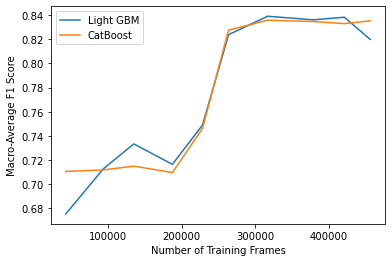

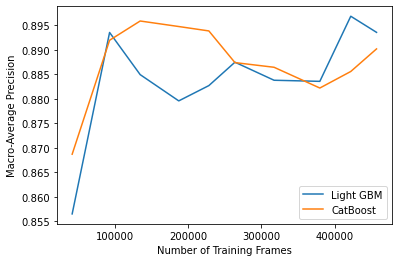

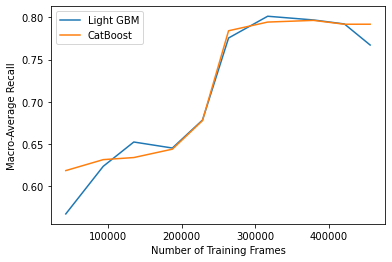

In [40]:
import pickle
from matplotlib import pyplot as plt

with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/light_gbm_performance", 'rb') as f:
    lgt_results = pickle.load(f)
        
with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/catboost_performance", 'rb') as f:
    cat_results = pickle.load(f)

plt.figure()
plt.plot(np.sum(training_set_sizes_frames, axis=1), np.mean(np.asarray(lgt_results[2])[:, 0:3], axis=1))
plt.plot(np.sum(training_set_sizes_frames, axis=1), np.mean(np.asarray(cat_results[2])[:, 0:3], axis=1))
plt.legend(["Light GBM", "CatBoost"])
plt.ylabel("Macro-Average F1 Score")
plt.xlabel("Number of Training Frames")
plt.show()

plt.figure()
plt.plot(np.sum(training_set_sizes_frames, axis=1), np.mean(np.asarray(lgt_results[0])[:, 0:3], axis=1))
plt.plot(np.sum(training_set_sizes_frames, axis=1), np.mean(np.asarray(cat_results[0])[:, 0:3], axis=1))
plt.legend(["Light GBM", "CatBoost"])
plt.ylabel("Macro-Average Precision")
plt.xlabel("Number of Training Frames")
plt.show()

plt.figure()
plt.plot(np.sum(training_set_sizes_frames, axis=1), np.mean(np.asarray(lgt_results[1])[:, 0:3], axis=1))
plt.plot(np.sum(training_set_sizes_frames, axis=1), np.mean(np.asarray(cat_results[1])[:, 0:3], axis=1))
plt.legend(["Light GBM", "CatBoost"])
plt.ylabel("Macro-Average Recall")
plt.xlabel("Number of Training Frames")
plt.show()

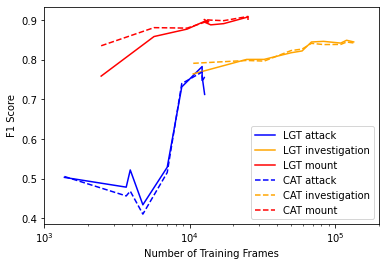

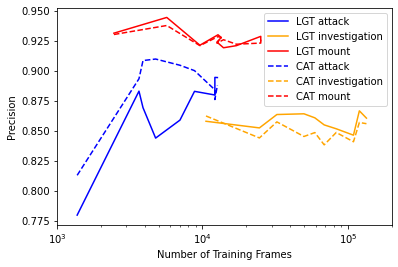

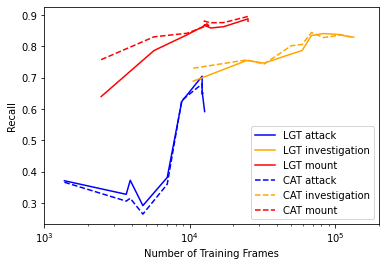

In [46]:
import pickle
from matplotlib import pyplot as plt

with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/light_gbm_performance", 'rb') as f:
    lgt_results = pickle.load(f)
        
with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/catboost_performance", 'rb') as f:
    cat_results = pickle.load(f)

plt.figure()
plt.plot(training_set_sizes_frames[:, 0], np.asarray(lgt_results[2])[:, 0], color='blue',label='LGT attack')
plt.plot(training_set_sizes_frames[:, 1], np.asarray(lgt_results[2])[:, 1], color='orange',label='LGT investigation')
plt.plot(training_set_sizes_frames[:, 2], np.asarray(lgt_results[2])[:, 2], color='red',label='LGT mount')

plt.plot(training_set_sizes_frames[:, 0], np.asarray(cat_results[2])[:, 0], ls='--', color='blue',label='CAT attack')
plt.plot(training_set_sizes_frames[:, 1], np.asarray(cat_results[2])[:, 1], ls='--', color='orange',label='CAT investigation')
plt.plot(training_set_sizes_frames[:, 2], np.asarray(cat_results[2])[:, 2], ls='--', color='red',label='CAT mount')
plt.legend()
plt.ylabel("F1 Score")
plt.xlabel("Number of Training Frames")
plt.xscale('log')
plt.xlim([1000, 200000])
plt.show()


plt.figure()
plt.plot(training_set_sizes_frames[:, 0], np.asarray(lgt_results[0])[:, 0], color='blue',label='LGT attack')
plt.plot(training_set_sizes_frames[:, 1], np.asarray(lgt_results[0])[:, 1], color='orange',label='LGT investigation')
plt.plot(training_set_sizes_frames[:, 2], np.asarray(lgt_results[0])[:, 2], color='red',label='LGT mount')

plt.plot(training_set_sizes_frames[:, 0], np.asarray(cat_results[0])[:, 0], ls='--', color='blue',label='CAT attack')
plt.plot(training_set_sizes_frames[:, 1], np.asarray(cat_results[0])[:, 1], ls='--', color='orange',label='CAT investigation')
plt.plot(training_set_sizes_frames[:, 2], np.asarray(cat_results[0])[:, 2], ls='--', color='red',label='CAT mount')
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Number of Training Frames")
plt.xscale('log')
plt.xlim([1000, 200000])
plt.show()


plt.figure()
plt.plot(training_set_sizes_frames[:, 0], np.asarray(lgt_results[1])[:, 0], color='blue',label='LGT attack')
plt.plot(training_set_sizes_frames[:, 1], np.asarray(lgt_results[1])[:, 1], color='orange',label='LGT investigation')
plt.plot(training_set_sizes_frames[:, 2], np.asarray(lgt_results[1])[:, 2], color='red',label='LGT mount')

plt.plot(training_set_sizes_frames[:, 0], np.asarray(cat_results[1])[:, 0], ls='--', color='blue',label='CAT attack')
plt.plot(training_set_sizes_frames[:, 1], np.asarray(cat_results[1])[:, 1], ls='--', color='orange',label='CAT investigation')
plt.plot(training_set_sizes_frames[:, 2], np.asarray(cat_results[1])[:, 2], ls='--', color='red',label='CAT mount')
plt.legend()
plt.ylabel("Recall")
plt.xlabel("Number of Training Frames")
plt.xscale('log')
plt.xlim([1000, 200000])
plt.show()



In [ ]:
# WIP CODE
## Loop over different training set sizes
##### WIP #####
import json
import numpy as np
import copy
import random
from behavior_classification import MARS_train_test

project_path = '/media/storage/ryan/mabe_challenge'

with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/train_features_0.json") as f:
    complete_training_set = json.load(f)

training_set_sizes = np.asarray([0.01])
training_set_sizes_frames = np.zeros((len(training_set_sizes), 4))

complete_training_set_total_frames = 0
for seq_name in complete_training_set["sequences"]["mabe_challenge"].keys():
    complete_training_set_total_frames += len(complete_training_set["sequences"]["mabe_challenge"][seq_name][0]["annotations"])

random.seed(42)
seq_names = list(complete_training_set["sequences"]["mabe_challenge"].keys())
random.shuffle(seq_names)

precision = []
recall = []
f1 = []

for iteration, training_set_size in enumerate(training_set_sizes):
    print("Loop: {}".format(iteration))
    
    training_set_frames = 0
    
    training_set = {}
    training_set["vocabulary"] = copy.deepcopy(complete_training_set["vocabulary"])
    training_set["feature_names"] = copy.deepcopy(complete_training_set["feature_names"])
    training_set["sequences"] = {}
    training_set["sequences"]["mabe_challenge"] = {}
    
    seq_index = 0
    
    
    while(training_set_frames < training_set_size * complete_training_set_total_frames):
        training_set["sequences"]["mabe_challenge"][seq_names[seq_index]] = copy.deepcopy(complete_training_set["sequences"]["mabe_challenge"][seq_names[seq_index]])
    
        training_set_frames += len(training_set["sequences"]["mabe_challenge"][seq_names[seq_index]][0]["annotations"])
        seq_index += 1
    
    # counts the number of frames for each behavior
    temp_behavior_counter = np.zeros(4)
    for training_set_seq_name in training_set["sequences"]["mabe_challenge"].keys():
        for behavior in range(4):
            temp_behavior_counter[behavior] += np.sum(np.asarray(training_set["sequences"]["mabe_challenge"][training_set_seq_name][0]["annotations"])==behavior)
    
    # if not all behaviors are included in the training set or the training set is less than one video long
    if training_set_frames == 0 or np.any(temp_behavior_counter == 0):
        secondary_shuffled_seq_names = random.shuffle(copy.deepcopy(seq_names))
        target_training_set_size_frames = training_set_size * complete_training_set_total_frames
        
        
        # loop through shuffled sequences for attack sequence
        attack_sequence_found = False
        for seq_index, seq_name in enumerate(secondary_shuffled_seq_names):
            sequence_length = len(complete_training_set["sequences"]["mabe_challenge"][secondary_shuffled_seq_names[[seq_index]]][0]["annotations"])
            # look for attack sequence
            for start_index in range(sequence_length - target_training_set_size_frames // 2):
                temp_behavior_counter = np.zeros(4)
                for behavior in range(4):
                    temp_behavior_counter[behavior] += np.sum(np.asarray(complete_training_set["sequences"]["mabe_challenge"][secondary_shuffled_seq_names[[seq_index]]][0]["annotations"])[start_index:start_index+target_training_set_size_frames // 2]==behavior)
                if (temp_behavior_counter[[0,1,3]] > 0) == np.asarray([True, True, True]):
                    training_set["sequences"]["mabe_challenge"][seq_name] = copy.deepcopy(complete_training_set["sequences"]["mabe_challenge"][seq_names])
                    training_set["sequences"]["mabe_challenge"][seq_name][0]['features'] = training_set["sequences"]["mabe_challenge"][seq_name][0]['features'][start_index:start_index + target_training_set_size_frames // 2, :]
                    training_set["sequences"]["mabe_challenge"][seq_name][0]['features'] = training_set["sequences"]["mabe_challenge"][seq_name][0]['features'][start_index:start_index + target_training_set_size_frames // 2, :]
                    attack_sequence_found = True
                    print("attack sequence found")
                    break
        if attack_sequence_found == False:
            print("suitable attack sequence not found, skipping")
            break
        
        secondary_shuffled_seq_names.remove(seq_name)
        mount_sequence_found = False
        for seq_index, seq_name in enumerate(secondary_shuffled_seq_names):
            sequence_length = len(complete_training_set["sequences"]["mabe_challenge"][secondary_shuffled_seq_names[[seq_index]]][0]["annotations"])
            # look for attack sequence
            for start_index in range(sequence_length - target_training_set_size_frames // 2):
                temp_behavior_counter = np.zeros(4)
                for behavior in range(4):
                    temp_behavior_counter[behavior] += np.sum(np.asarray(complete_training_set["sequences"]["mabe_challenge"][secondary_shuffled_seq_names[[seq_index]]][0]["annotations"])[start_index:start_index+sequence_length]==behavior)
                if (temp_behavior_counter[[1,2,3]] > 0) == np.asarray([True, True, True]):
                    mount_sequence_found = True
                    print("mount sequence found")
                    break
        if mount_sequence_found == False:
            print("suitable mount sequence not found, skipping")
            break
        
            
    val_set_size = 0.1 #initial tests used 0.1
    val_set_frames = 0

    val_set = {}
    val_set["vocabulary"] = copy.deepcopy(training_set["vocabulary"])
    val_set["feature_names"] = copy.deepcopy(training_set["feature_names"])
    val_set["sequences"] = {}
    val_set["sequences"]["mabe_challenge"] = {}

    seq_index = 0

    if len(training_set["sequences"]["mabe_challenge"].keys()) > 1:
        while(val_set_frames < val_set_size * training_set_frames):
            val_set["sequences"]["mabe_challenge"][seq_names[seq_index]] = copy.deepcopy(training_set["sequences"]["mabe_challenge"][seq_names[seq_index]])
            training_set["sequences"]["mabe_challenge"].pop(seq_names[seq_index])


            val_set_frames += len(val_set["sequences"]["mabe_challenge"][seq_names[seq_index]][0]["annotations"])
            seq_index += 1
        
    
    # counts the number of frames for each behavior
    temp_behavior_counter = np.zeros(4)
    for val_set_sequence_name in val_set["sequences"]["mabe_challenge"].keys():
        for behavior in range(4):
            temp_behavior_counter[behavior] += np.sum(np.asarray(val_set["sequences"]["mabe_challenge"][val_set_sequence_name][0]["annotations"])==behavior)
    
    # if not all behaviors are included in the training set or the training set is less than one video long
    if training_set_frames == 0 or np.any(temp_behavior_counter == 0):
        secondary_shuffled_seq_names = random.shuffle(copy.deepcopy(seq_names))
        target_training_set_size_frames = training_set_size * complete_training_set_total_frames
        
        
        # loop through shuffled sequences for attack sequence
        attack_sequence_found = False
        for seq_index, seq_name in enumerate(secondary_shuffled_seq_names):
            sequence_length = len(complete_training_set["sequences"]["mabe_challenge"][secondary_shuffled_seq_names[[seq_index]]][0]["annotations"])
            # look for attack sequence
            for start_index in range(sequence_length - target_training_set_size_frames // 2):
                temp_behavior_counter = np.zeros(4)
                for behavior in range(4):
                    temp_behavior_counter[behavior] += np.sum(np.asarray(complete_training_set["sequences"]["mabe_challenge"][secondary_shuffled_seq_names[[seq_index]]][0]["annotations"])[start_index:start_index+sequence_length]==behavior)
                if (temp_behavior_counter[[0,1,3]] > 0) == np.asarray([True, True, True]):
                    attack_sequence_found = True
                    print("attack sequence found")
                    break
        if attack_sequence_found == False:
            print("suitable attack sequence not found, skipping")
            break
        
        secondary_shuffled_seq_names.remove(seq_name)
        mount_sequence_found = False
        for seq_index, seq_name in enumerate(secondary_shuffled_seq_names):
            sequence_length = len(complete_training_set["sequences"]["mabe_challenge"][secondary_shuffled_seq_names[[seq_index]]][0]["annotations"])
            # look for attack sequence
            for start_index in range(sequence_length - target_training_set_size_frames // 2):
                temp_behavior_counter = np.zeros(4)
                for behavior in range(4):
                    temp_behavior_counter[behavior] += np.sum(np.asarray(complete_training_set["sequences"]["mabe_challenge"][secondary_shuffled_seq_names[[seq_index]]][0]["annotations"])[start_index:start_index+sequence_length]==behavior)
                if (temp_behavior_counter[[1,2,3]] > 0) == np.asarray([True, True, True]):
                    mount_sequence_found = True
                    print("mount sequence found")
                    break
        if mount_sequence_found == False:
            print("suitable mount sequence not found, skipping")
            break
    
    print("val set size: {}".format(val_set_frames))
    
    for training_set_seq_name in training_set["sequences"]["mabe_challenge"].keys():
        for behavior in range(4):
            training_set_sizes_frames[iteration, behavior] += np.sum(np.asarray(training_set["sequences"]["mabe_challenge"][training_set_seq_name][0]["annotations"])==behavior)
    print("training set size: {}".format(np.sum(training_set_sizes_frames[iteration])))

        
    with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/val_features.json", 'w') as f:
        json.dump(val_set, f)

    with open("/media/storage/ryan/mabe_challenge/behavior/behavior_jsons/train_features.json", 'w') as f:
        json.dump(training_set, f)
    
    results = MARS_train_test.train_classifier(project_path, ['investigation'])
    temp_precision, temp_recall, temp_f1 = MARS_train_test.test_classifier(project_path, ['investigation'])
    
    precision.append(temp_precision)
    recall.append(temp_recall)
    f1.append(temp_f1)